
------

- [Principal Components Analysis (PCA)](#Principal-Component-Analysis)
    - Intuition
    - Application of PCA - US Arrests
- [Multi-Dimensional Scaling (MDS)](#Multi-Dimensional-Scaling)
    - simple example 
    - MDS on US Arrests
    - on Amazon sentiment sentences text data
- [t-distributed Stochastic Neighbor Embedding (t-SNE) on text data](#t-Stochastic-Neighbor-Embedding)
- [Application of PCA dimension reduction on the AT&T Database of Faces images](#Eigenfaces)
- [Principal Component Regression](#Principal-Component-Regression)
- [Linear Discriminant Analysis](#Linear-Discriminant-Analysis)
- Q/A time
-------


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd

import sklearn
from sklearn import datasets, feature_selection, cluster, feature_extraction
from sklearn import neighbors, decomposition, metrics, preprocessing
from sklearn import model_selection

#from sklearn import cluster
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS


# do conda install nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from IPython import display

# Do conda install pillow
from PIL import Image
import os
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
set2_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

bold_colors = ['#FF0000', '#00FF00', '#FFAAAA', '#0000FF']
light_colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF', '#00FF00']
cmap_light = ListedColormap(light_colors)
cmap_bold = ListedColormap(bold_colors)
dark2_cmap = ListedColormap(dark2_colors)
set2_cmap = ListedColormap(dark2_colors)
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 12
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
def cible_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Make a target axis at 0,0 with ticks along the axis lines
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

![How are you coming along with Python](https://imgs.xkcd.com/comics/python.png)  


[Some rights reserved -- xkcd.com](https://xkcd.com/license.html)

<a id='Principal-Component-Analysis'></a>
[back to top](#top)

## Principal Component Analysis:

Goal:
- Reduce dimensionality of the dataset with minimal loss of information.
- compress data without much loss of information, e.g., image compression

Principal Components:
- A subset of ordered abstract projection that can best preserve the variations and correlations of the original data
- A dataset with $n$ instances and $p$ features ($p$-dimensional data) can be approximately reproduced using $k < p$ Principal Components 

Mathematically:
- An eigendecomposition of the covariance matrix
- Finds directions that maximize the variance in the dataset.
- In PCA, we are projecting the entire set of data onto a different subspace
- In PCA, we are trying to find the axes with maximum variances where the data is most spread

We might be interested in keeping only those eigenvectors with the largest eigenvalues, since they contain more information about the data. 

Create new feature subspace:
- eigenvalues that are close to 0 are less informative: they are dropped when we construct new feature subspace.

Algorithms for PCA
- Load a dataset that consists of $p$ features
- Compute the covariance matrix of the data
- Compute the eigenvalues and the corresponding eigenvectors
- Sort the eigenvectors by decreasing eigenvalues
- Select the top $k$ eigenvectors with the largest eigenvalues to form $p \times k$ matrix
- Use the $p \times k$ eigenvector matrix to transform the sample to a new subspace.

Step-by-step Examples
- US Arrests data
- Eigenfaces

PCA function in Python echosystem
- [Scikit-learn: sklearn.decomposition module](http://scikit-learn.org/stable/modules/decomposition.html#pca)
- [matplotlib](http://blog.nextgenetics.net/?e=42)

## Step-by-step example - using  2D data points based on note from a tutorial on pca 
http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf  
 - Some code is givn in Scilab (free alternative to Matlab)
 - We will use Python and associated libraries

---

### Step 1: Create and plot the raw data

In [4]:
x = [-0.4, -0.3, 0.3, 2.5,0.5, 2.2, 1.9, 3.1, 2.3, 2, 1, 1.5, 1.1]
y = [-0.7,-0.4, 0., 2.4, 0.7, 2.9, 2.2,3.0,2.7,1.6,1.1,1.6,0.9]
data = np.array([x,y]).T
df = pd.DataFrame(data, columns=['x', 'y'])
df.head()

,x,y
0,-0.4,-0.7
1,-0.3,-0.4
2,0.3,0.0
3,2.5,2.4
4,0.5,0.7


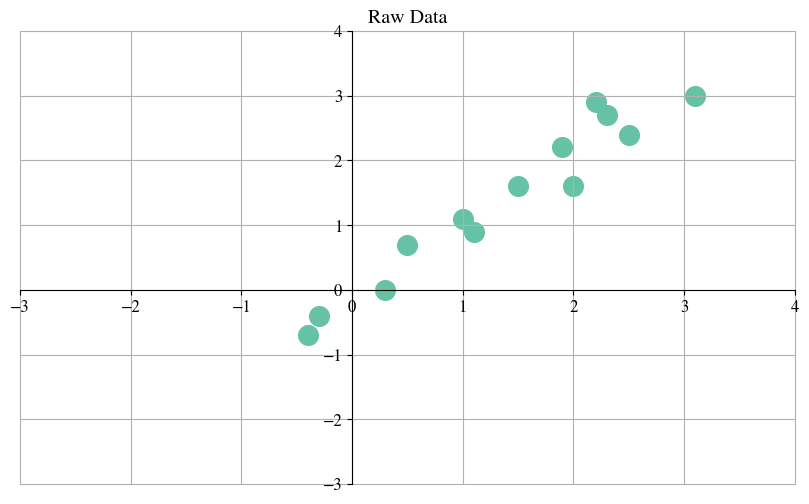

In [5]:
ax = plt.gca()
ax.axis([-3, 4, -3, 4])
ax.scatter(df.x, df.y, s=200, c=set2_colors[0])
ax.set_title('Raw Data')
ax.grid(True)
cible_border()
plt.show()

### Step 2: Subtract the mean (center of gravity)
#### - Reviewed in the Lecture notes 

x    1.361538
y    1.384615
dtype: float64


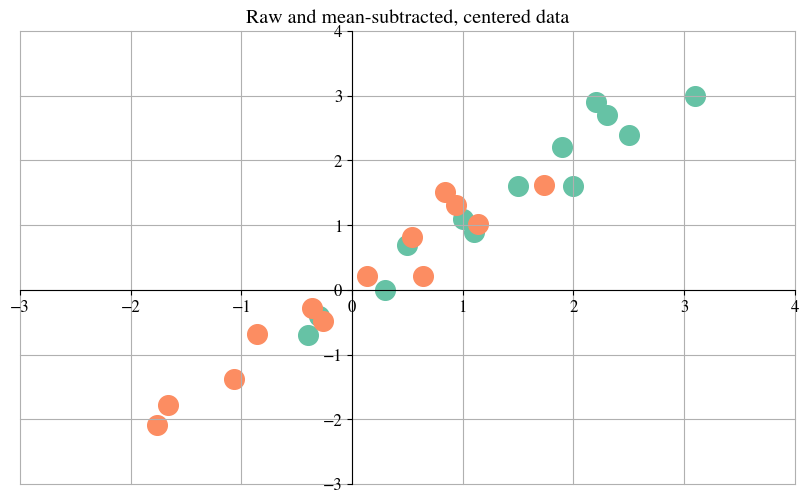

In [6]:
mu = df.mean(axis=0)
print (mu)

df_0 = df - mu
ax = plt.gca()
ax.axis([-3, 4, -3, 4])
ax.scatter(df.x, df.y, s=200, c=set2_colors[0])
ax.scatter(df_0.x, df_0.y, s=200, c=set2_colors[1])
ax.set_title('Raw and mean-subtracted, centered data')
ax.grid(True)
cible_border()

plt.show()

### Step 3: Calculate the covariance matrix $\Sigma$

In [7]:
#C = np.cov(df.T)
#C = np.cov(df, rowvar=0)
C = np.cov(df_0.x,df_0.y)
print(C)

[[ 1.2125641   1.33352564]
 [ 1.33352564  1.55474359]]


### Step 4: Calculate the eignvector and eigenvalues of the covariance matrix
- Recall the discussion from lecture about the eigenvales and eigenvectors of positive semidefinite matrix. 
- C is positives semidefinite (x*Cx >= 0) and symmetric

In [8]:
eigenvalues, eigenvectors = np.linalg.eigh(C)
print('Eigenvalues \n%s\n' %eigenvalues)
print('Eigenvectors \n%s' %eigenvectors)

Eigenvalues 
[ 0.0391977   2.72810999]

Eigenvectors 
[[-0.75075153  0.66058469]
 [ 0.66058469  0.75075153]]


###  The eigenvectors are all orthonormal

In [9]:
print(np.dot(eigenvectors[1], eigenvectors[0]))
print('')
for vec in eigenvectors:
    print(np.linalg.norm(vec))
print(eigenvectors[:,1])

0.0

1.0
1.0
[ 0.66058469  0.75075153]


#### Sort the eignvalues in descending order

In [10]:
##looking for largest eigen value with the largest variance if you can divide first eigen value by sum of two eigen
##values then the result is the variance explained by the first eigen value
#have up to p eigen values
idx = np.argsort (-eigenvalues )
eigenvalues = eigenvalues [ idx ]
eigenvectors = eigenvectors [: , idx ]
print(eigenvalues)
print(idx)
print('')
print(eigenvectors)
print('')
print(eigenvectors[:,0])

[ 2.72810999  0.0391977 ]
[1 0]

[[ 0.66058469 -0.75075153]
 [ 0.75075153  0.66058469]]

[ 0.66058469  0.75075153]


#### Check the the SVD decomposition

In [11]:
S = eigenvalues*np.eye(2)
U = eigenvectors
V = U
D = np.dot(U, np.dot(S,  V.T))
D

array([[ 1.2125641 ,  1.33352564],
       [ 1.33352564,  1.55474359]])

In [12]:
np.allclose(C,D)

True

### Visualize the Principal Components

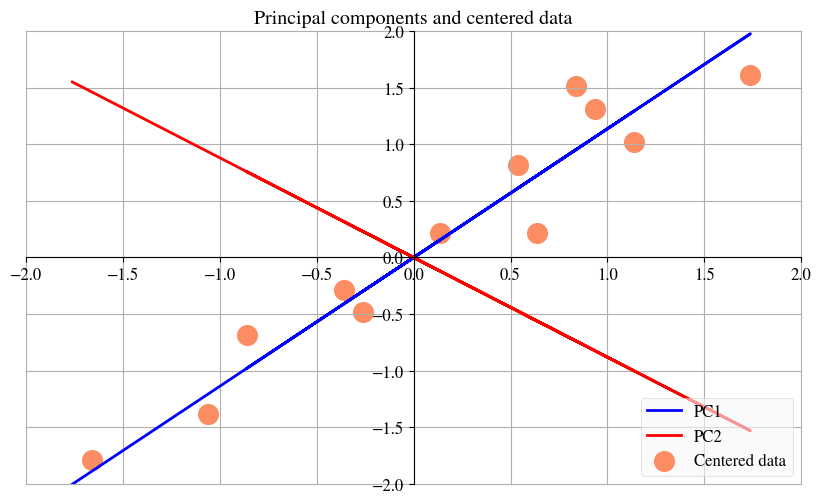

In [13]:
h1 = (eigenvectors[1][0]/eigenvectors[0][0])*df_0.x
h2 = (eigenvectors[1][1]/eigenvectors[0][1])*df_0.x

ax = plt.gca()
ax.plot(df_0.x, h1, color='blue', label='PC1')
ax.plot(df_0.x, h2, color='red', label='PC2')
ax.axis([-2, 2, -2, 2])
ax.scatter(df_0.x, df_0.y, s=200, c=set2_colors[1], label='Centered data')
ax.set_title('Principal components and centered data')
ax.grid(True)
cible_border()
legend = ax.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.6)
plt.show()

### Step 5: Dimensionality Reduction - select the principal component(s) 

#### Check the principal component 
- Principal component: eigenvectors[:,0]

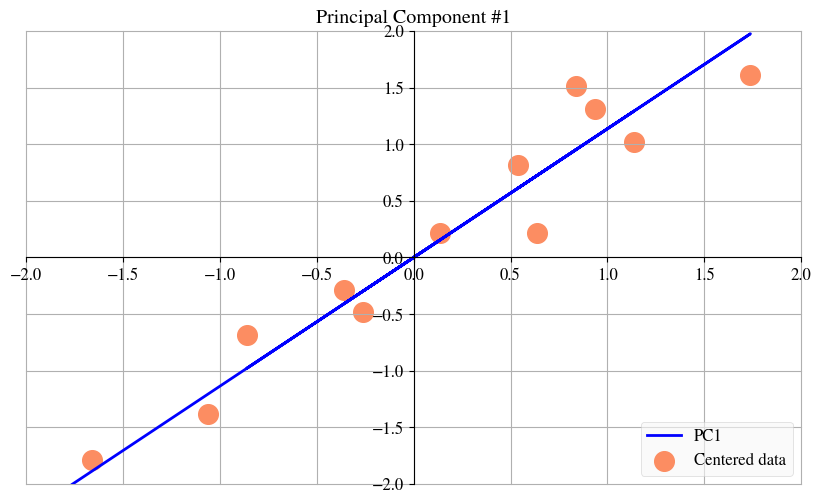

In [14]:
h = (eigenvectors[1][0]/eigenvectors[0][0])*df_0.x
ax = plt.gca()
ax.plot(df_0.x, h, color='blue', label='PC1')
ax.axis([-2, 2, -2, 2])
ax.scatter(df_0.x, df_0.y, s=200, c=set2_colors[1], label='Centered data')
ax.set_title('Principal Component #1')
ax.grid(True)
cible_border()
legend = ax.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.6)
plt.show()

#### Select the significant component (principal component)
- The second component can be ignored if we choose to keep one significant component
- The final dataset will have reduced dimension if the second component is ignored.
- Generally, some information could be lost, but may not be significant depending of the component.
- for d-dimensional original data, k < d principal components can be selected, which reduces the dimension of the new data.

#### Form Feature Vector  $V$ 
- Let us select only the eigenvector with higher eigenvalue
- Generally, k < d eigenvectors with the highest k eigenvalues

In [15]:
V = eigenvectors[:,0]
print(V)

[ 0.66058469  0.75075153]


### Step 6: Reduced Dimension - Create a new data $Y$ using the selected eigenvector(s)
- A case when only one component is selected.

In [16]:
Y= np.dot(df_0, V)
print(Y)

[-2.72867354 -2.43738961 -1.74073818  1.51435182 -1.08309517  1.69155218
  0.9678507   2.36115356  1.60746034  0.58345825 -0.45250221  0.2531659
 -0.53659405]


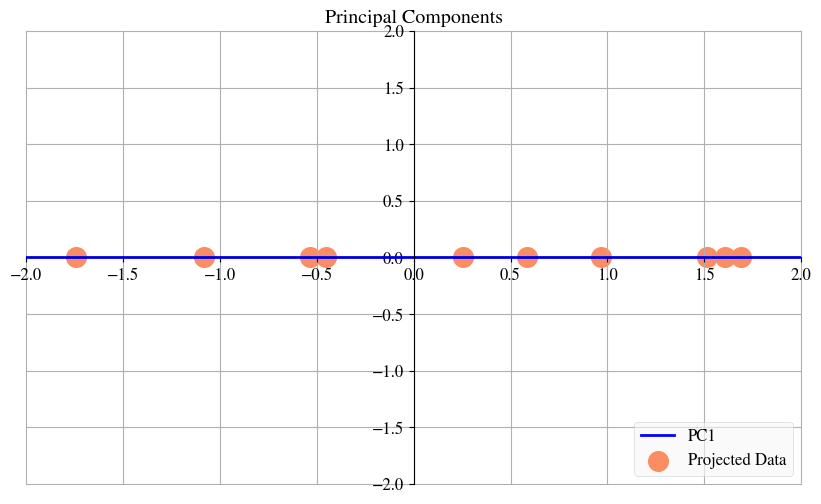

In [17]:
ax = plt.gca()
#ax.plot(df_0.x, np.dot(df_0, h), color='blue', label='PC1')
ax.axis([-2, 2, -2, 2])
ax.axhline(y=0, xmin=-2, xmax=2, color='blue', label='PC1')
ax.scatter(Y, np.zeros((len(Y))), s=200, c=set2_colors[1], label='Projected Data')
ax.set_title('Principal Components')
ax.grid(True)
cible_border()
legend = ax.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.6)
plt.show()

### Step 7: Recovering the original data 
- $Y = FA$
    - F: Feature vector
    - A: mean adjusted original data
    - Y: Transformed new data
- $A = F^{-1}Y$
    - Note: eigenvectors are normalized, so $F^{-1} = F^{T}$
    - $A = F^{T}Y$

#### Recovering mean adjusted original data - for single eigenvector case

In [18]:
Y = Y.reshape(1, Y.size)
V = V.reshape(1, V.size)
A = np.dot(V.T, Y)
A = A.T

#### Recovering original data by putting back the subtracted mean

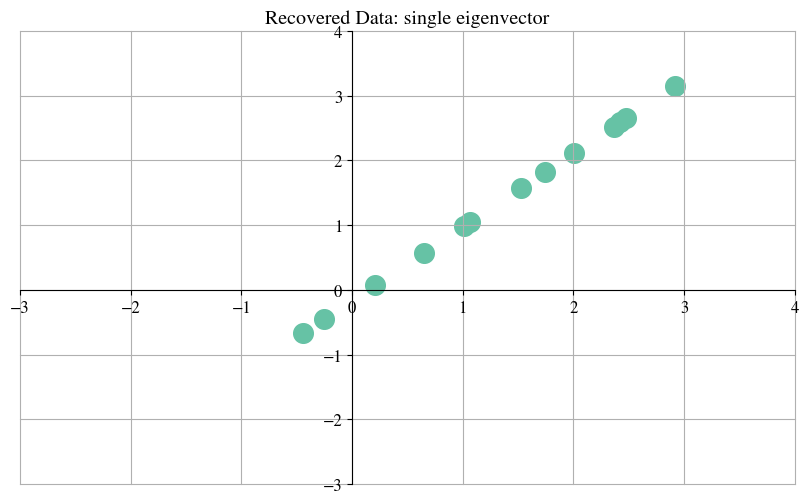

In [19]:
mu = mu.values.reshape(1, mu.size)
original = A + mu

ax = plt.gca()
ax.axis([-3, 4, -3, 4])
plt.scatter(original[:,0], original[:,1], s=200, c=set2_colors[0])
ax.set_title('Recovered Data: single eigenvector')
ax.grid(True)
cible_border()
plt.show()

#### Return to a case when both eigenvectors are kept 
- projection onto eigenvectors (rotation of axes)
- Feature vector contains both eigenvectors

[ 1.36153846  1.38461538]


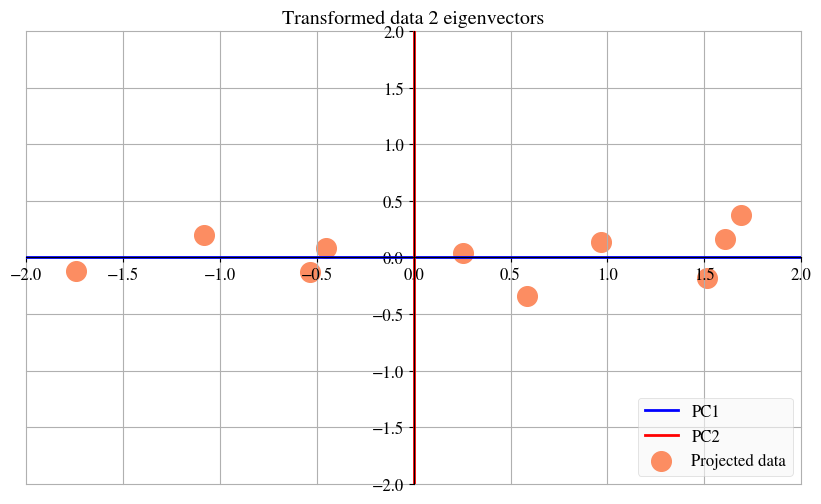

In [20]:
V = eigenvectors
Y= np.dot(df_0, V)

#print(Y)
print(mu[0])

ax = plt.gca()
ax.axhline(y=0, xmin=-2, xmax=2, color='blue', label='PC1')
ax.axvline(x=0, ymin=-2, ymax=2, color='red', label='PC2')
ax.axis([-2, 2, -2, 2])
ax.scatter(Y[:,0], Y[:,1], s=200, c=set2_colors[1], label='Projected data')
ax.set_title('Transformed data 2 eigenvectors')
ax.grid(True)
cible_border()
legend = ax.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.6)
plt.show()

#### Recovering original data - 2 eigenvector case

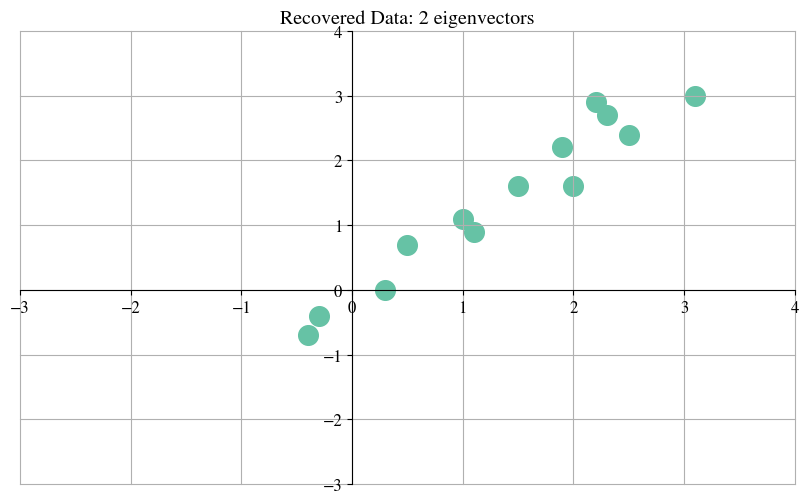

In [21]:
Y = Y.T
A = np.dot(V, Y)
A = A.T
mu = mu.reshape(1, mu.size)
original = A + mu

ax = plt.gca()
ax.axis([-3, 4, -3, 4])
ax.scatter(original[:,0], original[:,1], s=200, c=set2_colors[0])
ax.set_title('Recovered Data: 2 eigenvectors')
ax.grid(True)
cible_border()
plt.show()

## A look at real data - U.S. Arrests dataset

In [22]:
url = 'http://vincentarelbundock.github.io/Rdatasets/csv/datasets/USArrests.csv'
usarrests = pd.read_csv(url,sep=',')
usarrests.columns = usarrests.columns.str.replace('Unnamed: 0','State')
usarrests.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [23]:
usarrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [24]:
usarrests_scaled = usarrests.copy()
usarrests_scaled.iloc[:,1:] = preprocessing.StandardScaler().fit_transform(usarrests_scaled.iloc[:,1:])
usarrests_scaled.describe()

,Murder,Assault,UrbanPop,Rape
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,-8.437695e-17,1.298961e-16,-4.263256e-16,8.326673e-16
std,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00
min,-1.620693e+00,-1.524362e+00,-2.340661e+00,-1.502548e+00
25%,-8.611383e-01,-7.486054e-01,-7.704502e-01,-6.640245e-01
50%,-1.247758e-01,-1.425453e-01,3.210209e-02,-1.220847e-01
75%,8.029251e-01,9.483628e-01,8.521012e-01,5.330962e-01
max,2.229265e+00,2.015028e+00,1.776781e+00,2.671197e+00


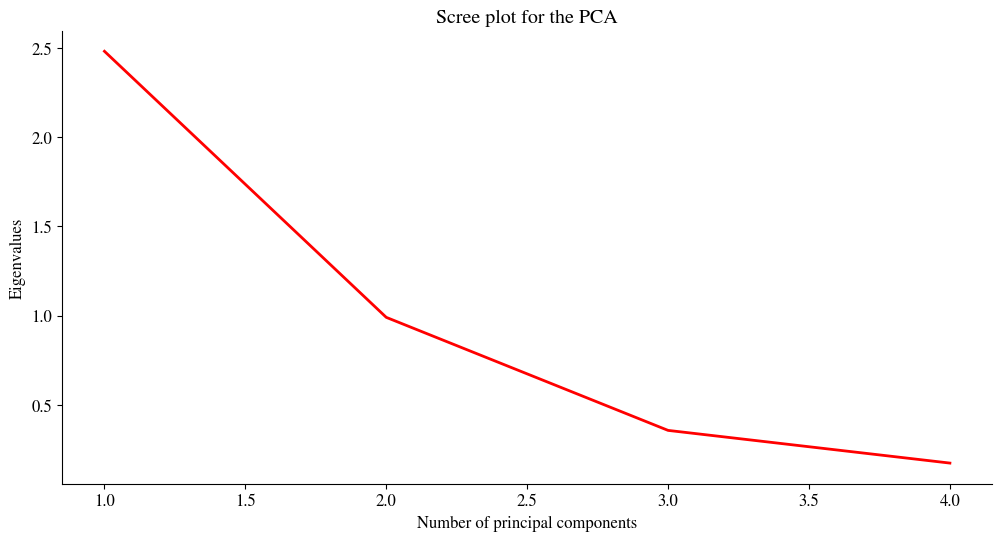

The 1st Principal Component explains 62.0 % of the variance

The 1st and 2nd Principal Components explain 86.8 % of the variance

The 1st, 2nd and 3rd Principal Components explain 95.7 % of the variance

The first four Principal Components explain 100.0 % of the variance



In [25]:
pca = sklearn.decomposition.PCA(n_components=4).fit(usarrests_scaled.iloc[:,1:])

coef_PCA = pca.transform(usarrests_scaled.iloc[:,1:])
# we make a scree plot to see how many Principal Components to consider
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
print ('The first four Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))

### Results
The first two Principal Components explain almost 87% of the variation in the data. Since we can plot these two components in a single scatterplot, we have an effective way of showing the data concisely in a reduced dimension space - rather than 6 separate scatterplots for all combinations of the 4 original features.

In [26]:
coef_PCA.shape

(50, 4)

### Principal Component score in a plot

---

#### Let's plot out the states in a scatterplot accoring to the coefficients of the PC scores

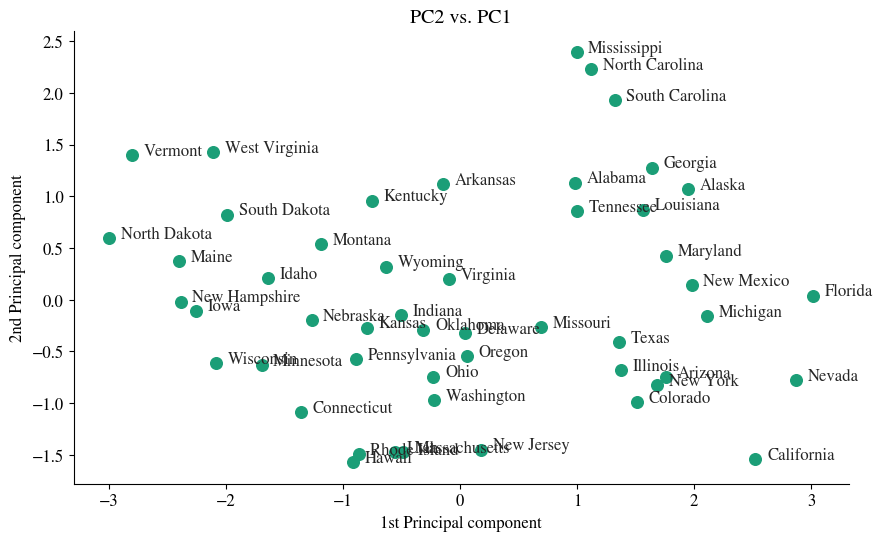

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(coef_PCA[:,0], coef_PCA[:,1], s = 70, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], usarrests_scaled.iloc[i]['State'],  zorder=1, size=12, color=shade_black)  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

### Looking at the plot of PC2 against PC1, what is your interpretation of the axes?

--- 

Next, let's plot the third Principal Component against the first

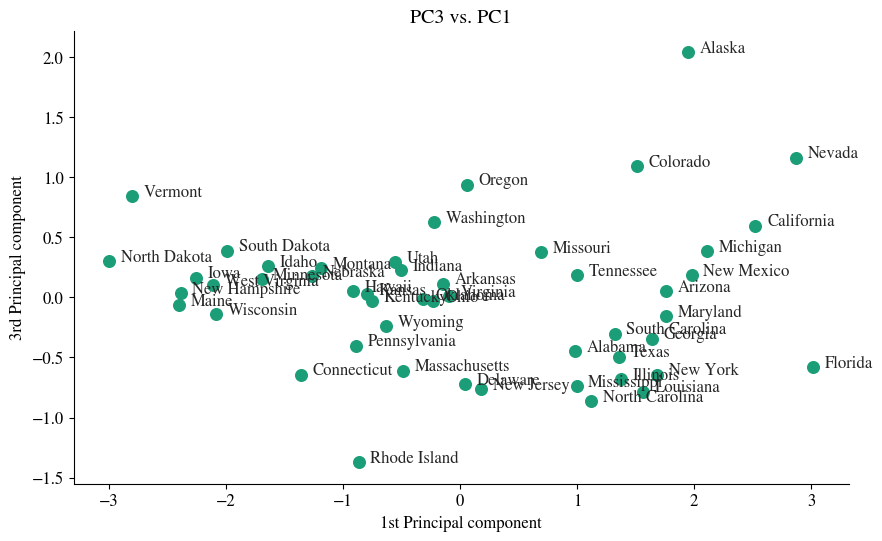

In [28]:
plt.figure(figsize=(10,6))
plt.scatter(coef_PCA[:,0], coef_PCA[:,2], s = 70, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,2], usarrests_scaled.iloc[i]['State'], zorder=1, size=12, color=shade_black) 
plt.ylabel('3rd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC3 vs. PC1')
remove_border()
plt.show()

### Again, from the plot of PC3 against PC1, what is your interpretation of PC3 axis?

---

We can also plot all three of the first Principal Components together in a 3D scatterplot

<IPython.core.display.Javascript object>


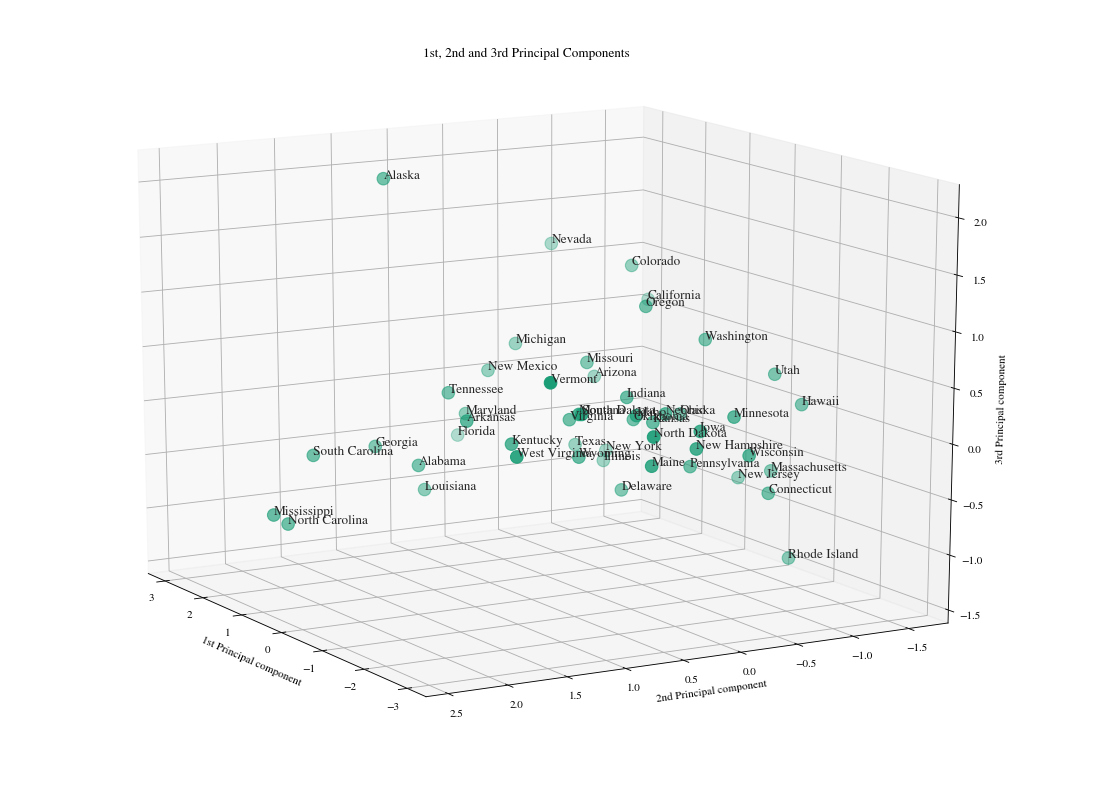

In [30]:
%matplotlib notebook

fig = plt.figure(1, figsize=(14, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=15, azim=150)
plt.cla()

ax.scatter(coef_PCA[:,0], coef_PCA[:,1], coef_PCA[:,2], s = 130, zorder=0, c=dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    ax.text(coef_PCA[i,0], coef_PCA[i,1], coef_PCA[i,2], usarrests_scaled.iloc[i]['State'], zorder=1, size=12, color=shade_black) 

ax.set_xlabel('1st Principal component')
ax.set_ylabel('2nd Principal component')
ax.set_zlabel('3rd Principal component')
ax.set_title('1st, 2nd and 3rd Principal Components')
plt.draw()

In [31]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()

In [32]:
from pandas.tools.plotting import scatter_matrix
#scatter_matrix(pd.DataFrame(text_PCA), alpha=0.7, figsize=(12, 12), color= 'b', diagonal='kde')
#plt.show()

### Feature loading plot
We can also plot the principal component loading vector coefficient for each of the features. This allows us to make an interpretation of the Principal Components on the basis of the dispersion of the feature loadings.

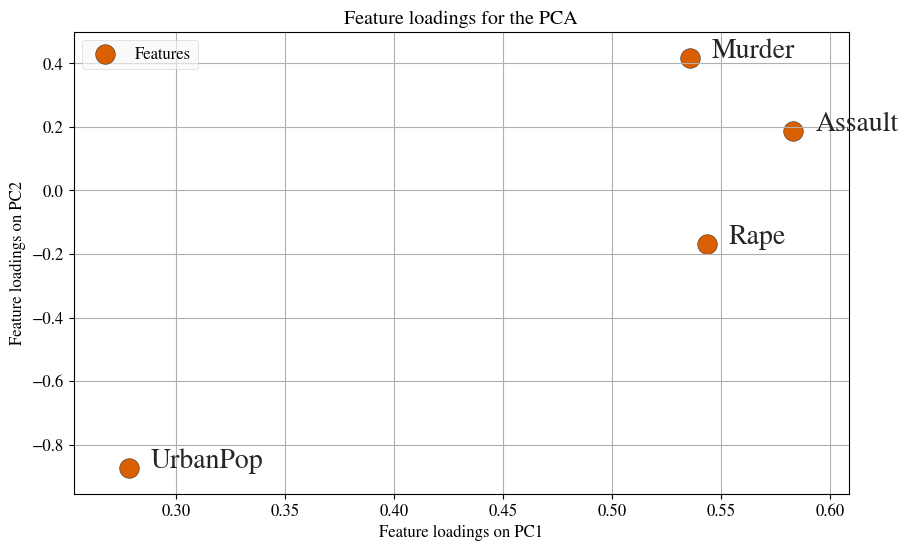

In [33]:
def make_loading_plot(components, cols):
    summ_up = lambda x, y: abs(x) + abs(y)
    loadings = pd.DataFrame(data=dict(X=components[0], Y=components[1], name=cols))
    #loadings['summ'] = loadings.apply(lambda row: summ_up(row['X'], row['Y']), axis=1)
    plt.scatter(loadings.X, loadings.Y, s=200, label="Features", 
                facecolor=dark2_colors[1], edgecolor=shade_black, linewidth=0.35);

    for i in range(loadings.shape[0]):
        plt.text(loadings.iloc[i]['X']+.01, loadings.iloc[i]['Y'], loadings.iloc[i]['name'], size=12, color=shade_black, fontsize =20)  

    plt.title("Feature loadings for the PCA");
    plt.xlabel("Feature loadings on PC1");
    plt.ylabel("Feature loadings on PC2");
    plt.grid(True)
    
    legend = plt.legend(loc=2,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.6)

make_loading_plot(pca.components_, usarrests_scaled.columns[1:])
#cible_border()
plt.show()

### Now, what is your interpretation of the Principal Component axes?

---

We see that the violent crimes have roughly equal coefficients on the (positive) end of PC1. They are also close together, which indicates correlation with each other. In contrast, UrbanPoP is much less. PC2 seems to oppose UrbanPop and the violent crime features - representing the degree of urbanization of the state. Note also that Rape and Murder are also separated by this PC.   

#### Let's look at both plots together, and interpret

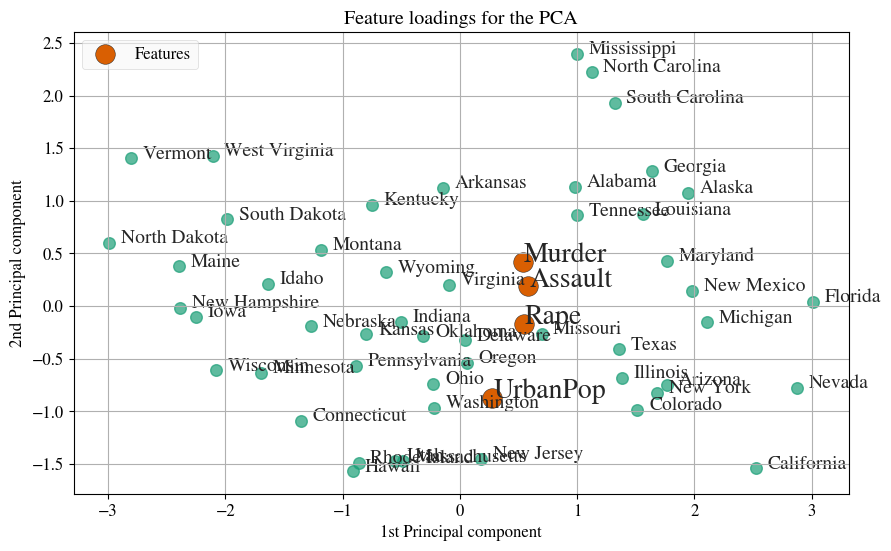

In [34]:
make_loading_plot(pca.components_, usarrests_scaled.columns[1:])
plt.scatter(coef_PCA[:,0], coef_PCA[:,1], s = 70, alpha=0.7, zorder=0, color = dark2_colors[0])
for i in range(coef_PCA.shape[0]):
    plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], usarrests_scaled.iloc[i]['State'],  zorder=1, size=14, color=shade_black)  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.show()

<a id='Multi-Dimensional-Scaling'></a>
[back to top](#top)

## [Multi-Dimensional Scaling](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling)

MDS attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.

There exists two types of MDS algorithm: metric and non metric. (Default is metric in scikit-learn) In scikit-learn, the class MDS implements both. In Metric MDS, the input similarity matrix arises from a metric (and thus respects the triangular inequality), the distances between output two points are then set to be as close as possible to the similarity or dissimilarity data. In the non-metric version, the algorithms will try to preserve the order of the distances, and hence seek for a monotonic relationship between the distances in the embedded space and the similarities/dissimilarities.

PCA tries to use optimization for retained variance, and on the other hand, MDS tries to retain the relative distances as much as possible when reducing the dimensions. This is useful when we have a high-dimensional dataset and want to get a visual impression.  
[[Building Machine Learning Systems with Python  By: Willi Richert; Luis Pedro Coelho](http://totoharyanto.staff.ipb.ac.id/files/2012/10/Building-Machine-Learning-Systems-with-Python-Richert-Coelho.pdf)]

### A simple example

In [35]:
#Dataset from R USCitiesD (library datasets)
uscitiesd = pd.read_csv("data/UScitiesD.csv")
uscitiesd

,0,Atlanta,Chicago,Denver,Houston,LosAngeles,Miami,NewYork,SanFrancisco,Seattle,Washington.DC
0,Atlanta,0,587,1212,701,1936,604,748,2139,2182,543
1,Chicago,587,0,920,940,1745,1188,713,1858,1737,597
2,Denver,1212,920,0,879,831,1726,1631,949,1021,1494
3,Houston,701,940,879,0,1374,968,1420,1645,1891,1220
4,LosAngeles,1936,1745,831,1374,0,2339,2451,347,959,2300
5,Miami,604,1188,1726,968,2339,0,1092,2594,2734,923
6,NewYork,748,713,1631,1420,2451,1092,0,2571,2408,205
7,SanFrancisco,2139,1858,949,1645,347,2594,2571,0,678,2442
8,Seattle,2182,1737,1021,1891,959,2734,2408,678,0,2329
9,Washington.DC,543,597,1494,1220,2300,923,205,2442,2329,0


In [36]:
x = uscitiesd.iloc[:,1:]
Euclid_dist = euclidean_distances(x)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=99)
mds_fit = mds.fit_transform(Euclid_dist)  # shape (n_components, n_samples)

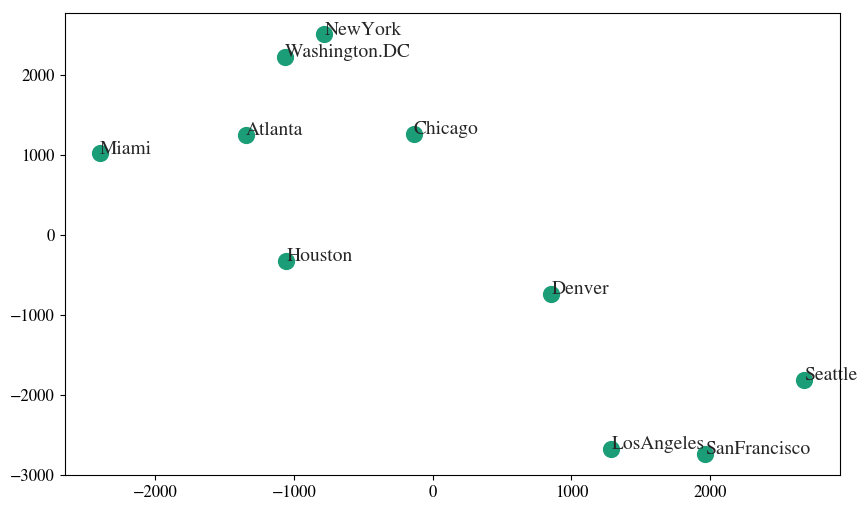

In [37]:
x1 = mds_fit[:,0]
y1 = mds_fit[:,1]
n = uscitiesd.iloc[:,0:1]

fig, ax = plt.subplots()
ax.scatter(x1,y1, s = 130, zorder=0, c=dark2_colors[0])

for i, txt in enumerate(n.values):
    ax.annotate(txt[0], (x1[i],y1[i]), zorder=1, size=14, color=shade_black)

### Feature reduction using Multi-Dimensional Scaling of US Arrests data

In [38]:
# Perform MDS to plot to several-dimensions
COV = np.cov(usarrests_scaled.iloc[:,1:])
mds = MDS(n_components=4, dissimilarity="precomputed", random_state=99)
text_MDS = mds.fit_transform(COV)  # shape (n_components, n_samples)

### Plot of MDS coefficients for US Arrests

We can make an alternative graphical representation using MDS instead of PCA and compare the differences.

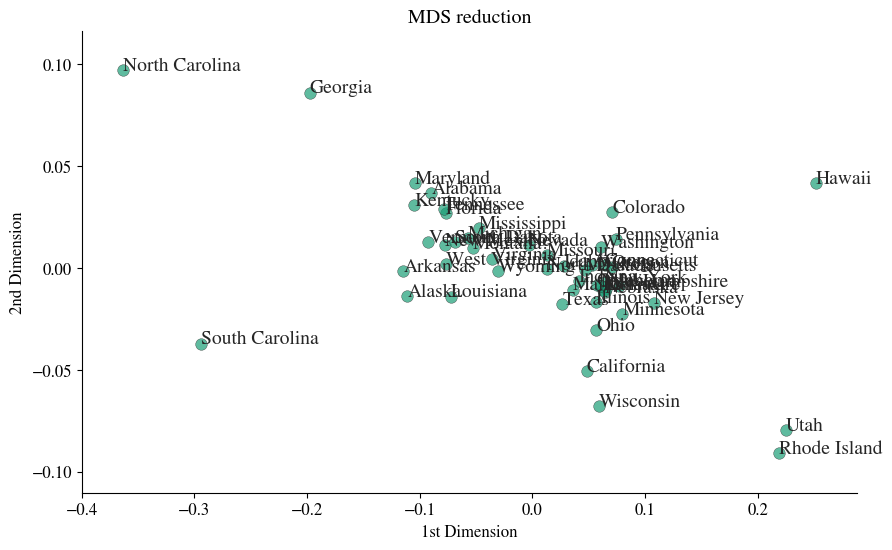

In [39]:
get_shape = text_MDS.shape[1]
columns = ["dimension"+str(i+1) for i in range(get_shape)]
mdsdf = pd.DataFrame(text_MDS, columns = columns)

plt.scatter(mdsdf.dimension1, mdsdf.dimension2, alpha = 0.7, s=70,
            facecolor=dark2_colors[0], edgecolor=shade_black, linewidth=0.35)
for i in range(mdsdf.shape[0]):
    plt.text(mdsdf.iloc[i]['dimension1'], mdsdf.iloc[i]['dimension2'], usarrests_scaled.iloc[i]['State'], zorder=1, size=14, color=shade_black)  
plt.ylabel('2nd Dimension' )
plt.xlabel('1st Dimension' )
plt.title('MDS reduction')

remove_border(top=False, right=False, left=True, bottom=True)
plt.show()
    


## MDS on a text dataset

Sentiment Labelled Sentences Dataset 
http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

We will only use amazon data.

````
Data Set Information:

This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015 
Please cite the paper if you want to use it :) 

It contains sentences labelled with positive or negative sentiment. 

======= 
Format: 
======= 
sentence score 

======= 
Details: 
======= 
Score is either 1 (for positive) or 0 (for negative)	
The sentences come from three different websites/fields: 

imdb.com 
amazon.com 
yelp.com 

For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets of reviews. 
We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected. 
````


In [40]:
amazon = pd.read_csv("data/sentiment_labelled_sentences/amazon_cells_labelled.txt", header=None,delimiter="\t",  quoting=3)    
amazon.columns = ['sentence','sentiment']

In [41]:
print(amazon.shape)
print(amazon.sentiment.value_counts())
amazon.head()

(1000, 2)
1    500
0    500
Name: sentiment, dtype: int64


,sentence,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### Punctuation
Use str.replace() to remove punctuation and numeric data.

In [42]:
amazon['sentence']=amazon.sentence.str.lower()
amazon['sentence']=amazon.sentence.str.replace("[^a-zA-Z]", " ",)  #Remove all punctuations/numbers. 
#You may want remove punctuations or keep them and count how many !, ; etc in data

### Stemming

For [stemming](http://en.wikipedia.org/wiki/Stemming) of words by breaking them down to their stem components, there are several options. The NLTK provides the [Snowball Stemmer](http://snowball.tartarus.org/); the [Porter Stemmer](http://tartarus.org/~martin/PorterStemmer/) is one of the more widely used stemming algorithms; and the Lancaster Stemmer.

Stemming, while useful for TF-IDF and rare word extraction, may also be eliminating key discriminitory words (i.e. caution: not to be blindly applied) 

In [43]:
porter = PorterStemmer()
def tokenizer_porter(text):
    #for word in text.split():
    #    print(word, porter.stem(word))
    return [porter.stem(word) for word in text.split()]

### Stopwords
A corpus of stopwords for English is included in the  [NLTK](http://www.nltk.org/) resources. However, some of the stopwords may be the most important in discriminating stylometrically between clusters. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", "in", "not", "so", "that", etc. 

#### If you do not already have the corpus on your computer, you need to download it using `nltk`

In [44]:
#import nltk
#nltk.download()

In [45]:
all_stopwords = stopwords.words('english') #Add your own stopwords = + ['s','t']
#all_stopwords

### Hint  - 'set' is your friend

In [46]:
start_time = time.clock()
s = [x.lower() for x in all_stopwords]
for text in amazon.sentence.values:
    [x for x in text.split() if x.lower() not in s]
print (time.clock() - start_time)

start_time = time.clock()
s = set([x.lower() for x in all_stopwords])
for text in amazon.sentence.values:
    [x for x in text.split() if x.lower() not in s]
print (time.clock() - start_time)

0.016661000000000925
0.0034399999999994435


### TF-IDF Vectorizer

In [47]:
#TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features.

vectorizer = TfidfVectorizer(tokenizer = tokenizer_porter,
                             stop_words=all_stopwords,
                             use_idf=False,
                             max_features = 100,ngram_range=(1,1))
train_data_features = vectorizer.fit_transform(amazon.sentence.values)
train_data_features = train_data_features.A #toarray()  
vocab = vectorizer.get_feature_names()

In [48]:
vocab[:10]

['also',
 'ani',
 'bad',
 'batteri',
 'becaus',
 'best',
 'better',
 'bluetooth',
 'bought',
 'buy']

In [49]:
df = pd.DataFrame()
df = pd.DataFrame(data=train_data_features,columns=vocab)

In [50]:
CS_dist = 1 - cosine_similarity(train_data_features)
Euclid_dist = euclidean_distances(train_data_features)

num_samples, num_features = train_data_features.shape
print ("num_samples:  %d, num_features: %d" %(num_samples,num_features))

num_samples:  1000, num_features: 100


In [51]:
print(df.shape, Euclid_dist.shape, CS_dist.shape)

(1000, 100) (1000, 1000) (1000, 1000)


In [52]:
df.head()

,also,ani,bad,batteri,becaus,best,better,bluetooth,bought,buy,...,veri,volum,wa,wast,wear,well,work,worst,would,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute the MDS coefficients

--- 
We can use MDS for the dimension reduction of the features. This has the advantage of using the cosine similarity of the TF-IDF matrix (transformed to dissimilarity) for the calculation of distances.

In [53]:
# The CS distance matrix comes from the above TF-IDF vectorization
# and as such is 'pre-computed' random state is specified.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=99)
text_MDS = mds.fit_transform(CS_dist)  # shape (n_components, n_samples)

In [54]:
text_MDS.shape

(1000, 2)

Now that have reduced dimension of the features in order to be able to visualize them , let's cluster the TF-IDF vectors using K-Means.

In [55]:
# Set the cluster names to be used in visualization: we won't need more than 2
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}

Then we perform K-Means on the TF-IDF matrix with the K++ initialisation and 4 clusters.

In [56]:
# We do K-Means with the K-Means++ initialization and 2 clusters
MAX_CLUSTERS = 2
kmeans = KMeans(init='k-means++', n_clusters=MAX_CLUSTERS, n_init=10)
kmeans.fit(train_data_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
df['KM_cluster'] = kmeans.predict(train_data_features)
df['KM_cluster'].replace(cluster_names, inplace=True)

In [58]:
print("\nTotal nummber of clusters and composition: ")
print (df['KM_cluster'].value_counts()[::-1])
print("\nSilhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_data_features, kmeans.labels_, sample_size=1000))


Total nummber of clusters and composition: 
Cluster 1    300
Cluster 2    700
Name: KM_cluster, dtype: int64

Silhouette Coefficient: 0.061


For a quick visualisation, we can use MultiDimensional Scaling coefficients to visualize in the same 2D and 3D spaces to look at the first dimensions.

---

We define some functions that will be useful to visualize scatterplots. Mostly, these just take a dataframe and a title and plot out the series: just additional code to define the matplotlib options.

In [59]:
################
#  Code to define some default plot types for the scatterplots

def plot_2D(groups, title):
    plt.figure(figsize=(10,6))
    for name, group in groups:
        plt.scatter(group.dimension1, group.dimension2, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    plt.ylabel('2nd Dimension' )
    plt.xlabel('1st Dimension' )
    plt.title(title)
    #plt.gca().xaxis.grid(True)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.6)
    plt.gca().grid(False)
    remove_border(top=False, right=False, left=True, bottom=True)
    plt.show()

def plot_3D(groups, title, elevation=15, azimuth=150):
    fig = plt.figure(figsize=(14,10))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=elevation, azim=azimuth)
    for name, group in groups:
        ax.scatter(group.dimension1, group.dimension2, group.dimension3, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    ax.set_zlabel('3rd Dimension' )
    ax.set_ylabel('2nd Dimension' )
    ax.set_xlabel('1st Dimension' )
    ax.set_title(title)
    legend = ax.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.2)
    plt.draw()
    
def plot_2D_withlabels(df,groups, title):
    plt.figure(figsize=(10,6))
    for name, group in groups:
        plt.scatter(group.dimension1, group.dimension2, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    for i in range(df.shape[0]):
        plt.text(df.ix[i]['dimension1'], df.ix[i]['dimension2'], df.ix[i]['title'], alpha = 0.8, color='grey', size=9)  
    plt.ylabel('2nd Dimension' )
    plt.xlabel('1st Dimension' )
    plt.title(title)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.2)
    plt.gca().grid(False)
    remove_border(top=False, right=False, left=True, bottom=True)
    plt.show()

def make_plot_frame(proj, labels, cluster, title):
    get_shape = proj.shape[1]
    dimensions = ["Dimension"+str(i) for i in range(get_shape)]
    columns = ["dimension"+str(i+1) for i in range(get_shape)]
    columns.extend(["label", "cluster", "title"])
    data = np.column_stack((proj, labels, cluster, title))
    clustergroups = pd.DataFrame(data, columns = columns)
    return clustergroups

In [60]:
df.loc[:,"amazonindex"] = amazon.index.values

We plot out the clusters.

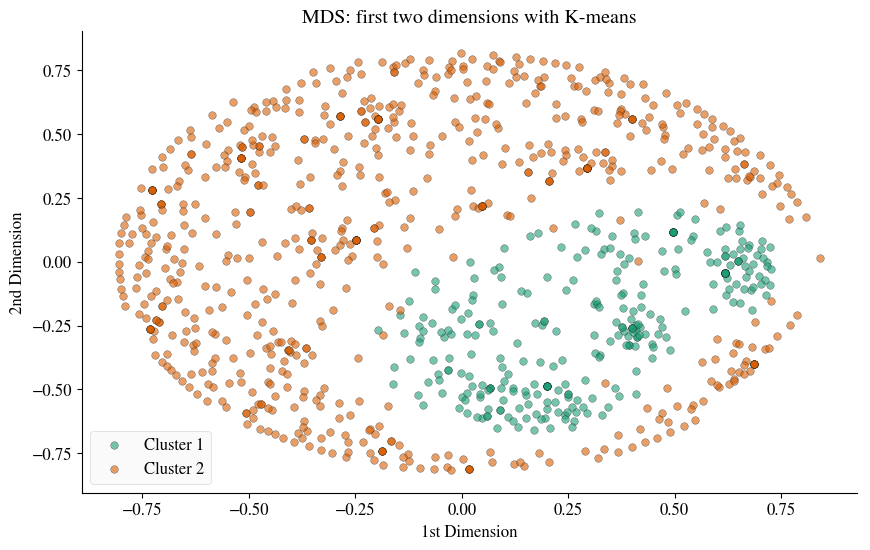

In [61]:
df1 = make_plot_frame(text_MDS, kmeans.labels_, df.loc[:,"KM_cluster"],df.loc[:,"amazonindex"])
clusterGroups = df1.groupby('label')

# Plot the features with MDS  
plot_2D(clusterGroups, 'MDS: first two dimensions with K-means')  

<a id='t-Stochastic-Neighbor-Embedding'></a>
[back to top](#top)

## t-Distributed Stochastic Neighbor Embedding

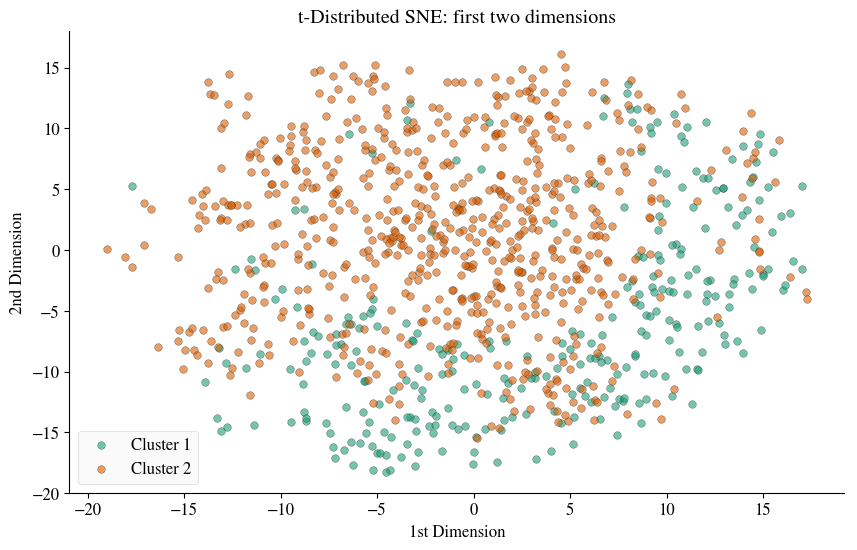

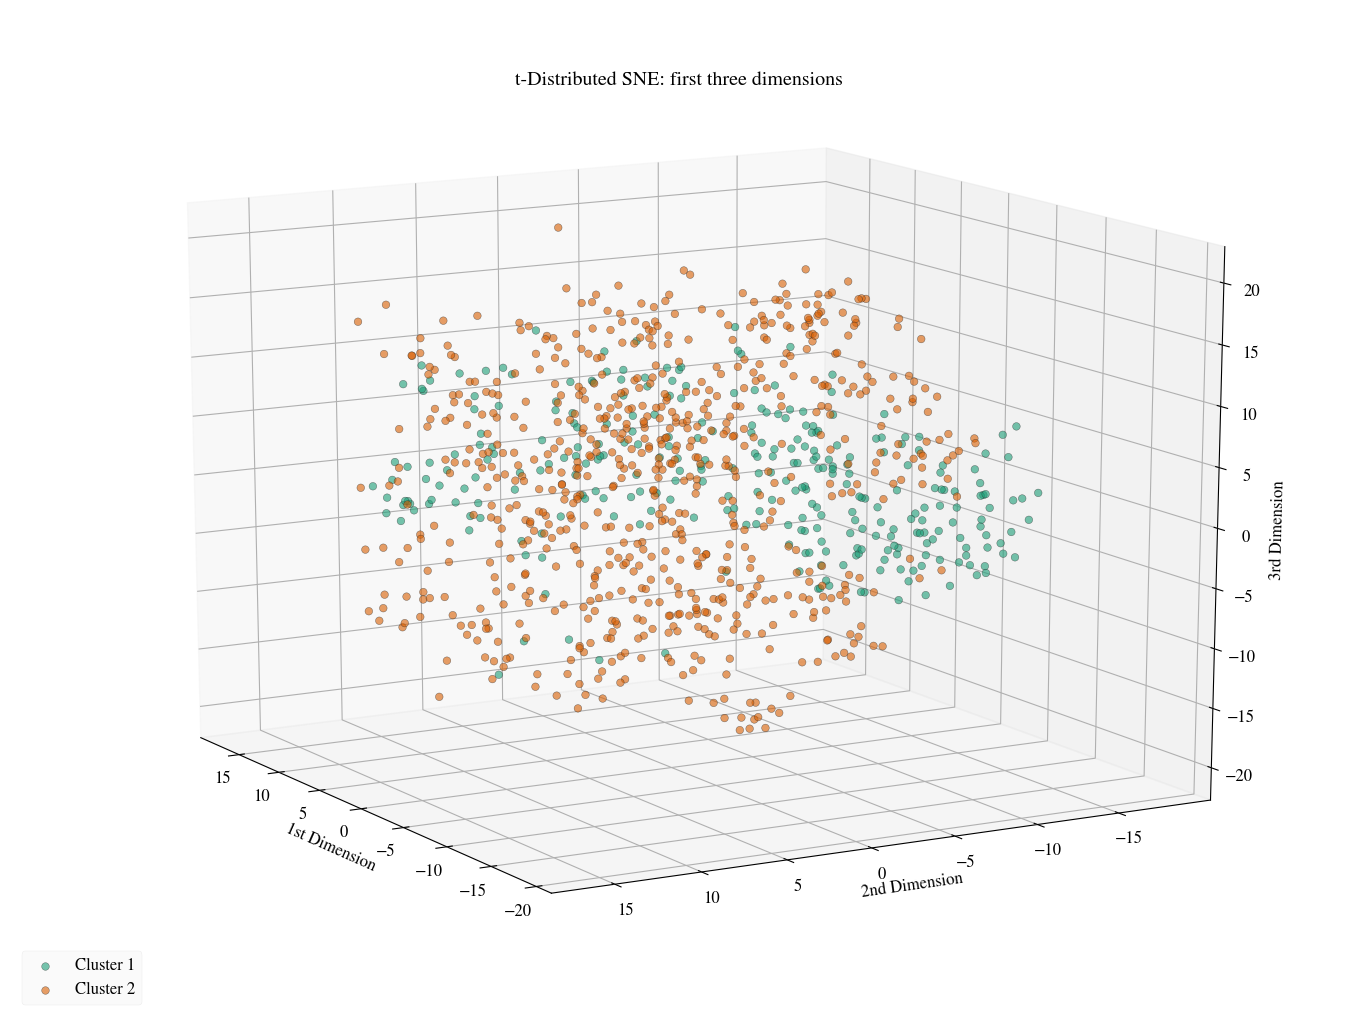

In [62]:
#t-Distributed Stochastic Neighbor Embedding
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(train_data_features)
X_embedded = TSNE(n_components=3, perplexity=40, verbose=0).fit_transform(X_reduced)

df2 = make_plot_frame(X_embedded, kmeans.labels_, df.loc[:,"KM_cluster"],df.loc[:,"amazonindex"])
clusterGroups = df2.groupby('label')

# Plot the features with t-SNE  
plot_2D(clusterGroups, 't-Distributed SNE: first two dimensions')
plot_3D(clusterGroups, 't-Distributed SNE: first three dimensions', 15, 150)

<IPython.core.display.Javascript object>


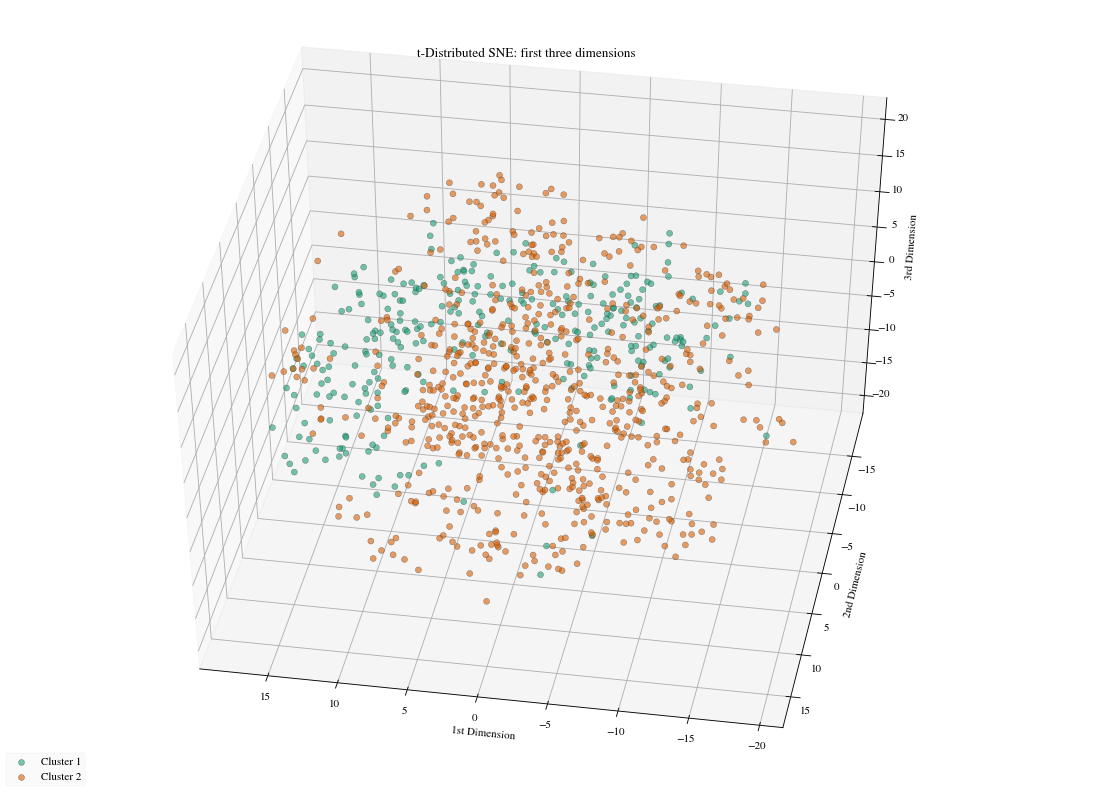

In [63]:
%matplotlib notebook
plot_3D(clusterGroups, 't-Distributed SNE: first three dimensions', 45, 100)

In [64]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()

## Application of PCA for image manipulation

<a id='Eigenfaces'></a>
[back to top](#top)

## Eigenfaces
- AT&T faces
- The database for the faces can be found in link below
- http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

This dataset contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge. The `sklearn.datasets.fetch_olivetti_faces` function is the data fetching / caching function that downloads the data archive from AT&T.

### [Here are all the original faces, in case you are interested](http://www.cl.cam.ac.uk/research/dtg/attarchive/facesataglance.html)

### Read images for file and populate the data into a matrix $X$ as a row data
- The images array has m x n image data 
- The data array has the m x n images in a row (flattened)
- The target array holds the subject's id, ranging from 0 to 39
- Each row holds one image data


In [65]:
faces = sklearn.datasets.fetch_olivetti_faces()

In [66]:
print('Shape of target array: ', faces.target.shape, '\n' )
print('Shape of images array: ', faces.images.shape, '\n' )
print('Shape of data array: ', faces.data.shape)

Shape of target array:  (400,) 

Shape of images array:  (400, 64, 64) 

Shape of data array:  (400, 4096)


### Examine original image using the function below.

64 64


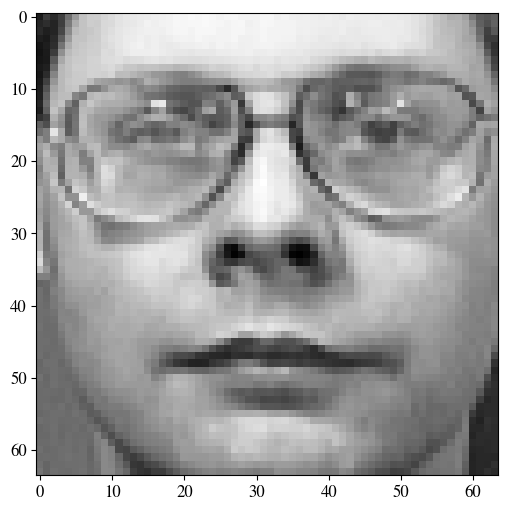

In [67]:
def view_original(image):
    
    plt.figure()
    plt.gray()
    plt.imshow(image)
    return np.array(image).shape[0:2]

m,n = view_original(faces.images[30,:])
print(m,n)

In [68]:
I = faces.data
print(I.shape)

(400, 4096)


## Perform PCA calculation

### Question:

### *How many Principal Components can I have, maximum? *

### Answer: 400 - because in this example we are treating the individual images as features, and the 4096 points as the data samples.  We can have a maximum of principal components equal to the number of features - i.e. the number of original images.   

In [69]:
def pca_calculation(I, num_components):
    [nv , d] = I.shape
    print(nv,d)
    mean_I = np.mean(I, 0)
    ma_I = I - mean_I
    # calculate the eigenvectors (eigenimages) and eigenvalues
    M = np.dot(ma_I,ma_I.T) #covariance matrix
    eigenvalues,eigenvectors = np.linalg.eigh(M)
    eigenvectors = np.dot(ma_I.T, eigenvectors)
    for i in range (nv):
        eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm ( eigenvectors [:, i])
    idx = np.argsort(-eigenvalues) #returns the index with increasing order 
                                   #(-z1 makes it decreasing order)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    print(M.shape[0:2])
    #return only num_components 
    eigenvalues = eigenvalues[0: num_components].copy()
    eigenvectors = eigenvectors[: ,0: num_components ].copy()
    return(eigenvalues, eigenvectors, mean_I)  

In [70]:
num_components = 40
eigenvalues, eigenvectors, mean_I = pca_calculation(I, num_components)

400 4096
(400, 400)


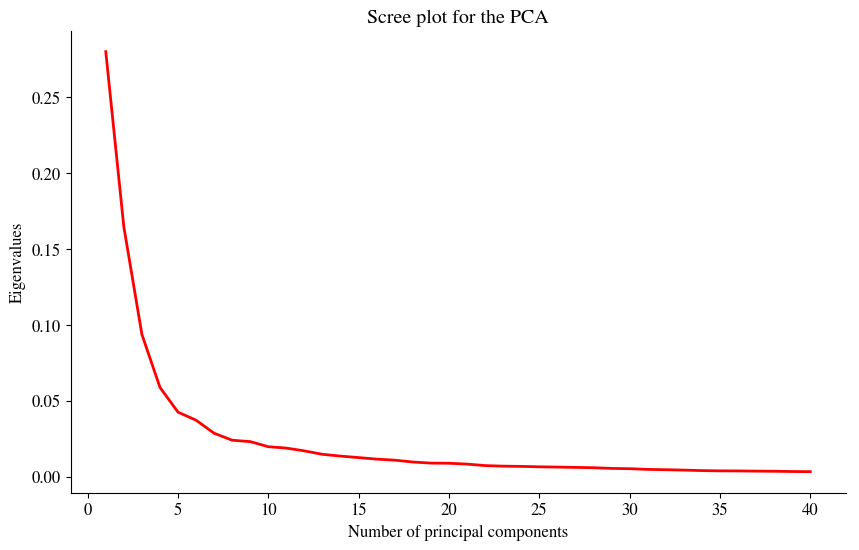

The 1st Principal Component explains 28.0 % of the variance

The 1st and 2nd Principal Components explain 44.4 % of the variance

The 1st, 2nd and 3rd Principal Components explain 53.8 % of the variance

The first four Principal Components explain 59.7 % of the variance

The first five Principal Components explain 63.9 % of the variance

The first six Principal Components explain 67.6 % of the variance



In [71]:
eig = eigenvalues/np.sum(eigenvalues)
var_exp = eig.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
print ('The first four Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))
print ('The first five Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[4]))
print ('The first six Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[5]))

### The mean of the images

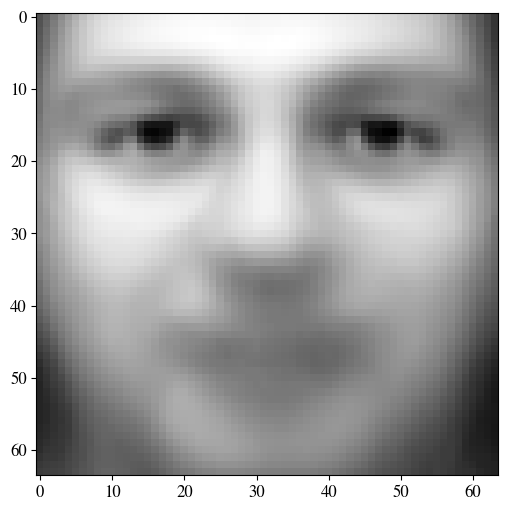

In [72]:
plt.figure()
plt.gray()
_ = plt.imshow(mean_I.reshape(m,n))

### Reconstructing the image

In [73]:
def pca_reconstruction(image, numEvs):
    weights = np.dot( I[image].reshape(1,-1) - mean_I, eigenvectors[: ,0: numEvs ])
    #reconstruct using principal components
    recon = mean_I + np.dot( weights, eigenvectors[: ,0: numEvs ].T)
    plt.figure()
    plt.gray()
    plt.imshow(recon.reshape(m,n))

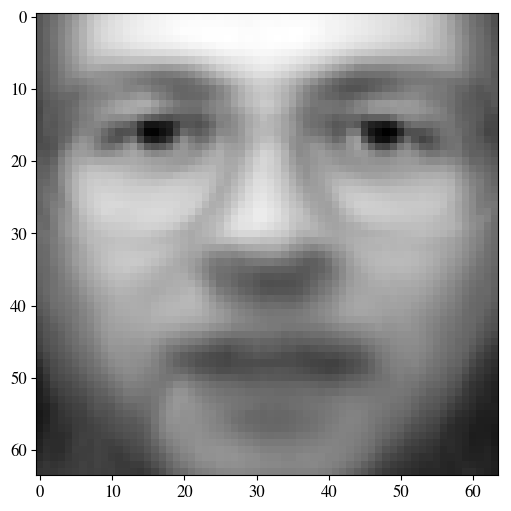

In [74]:
pca_reconstruction(30, 8)

400 4096
(400, 400)


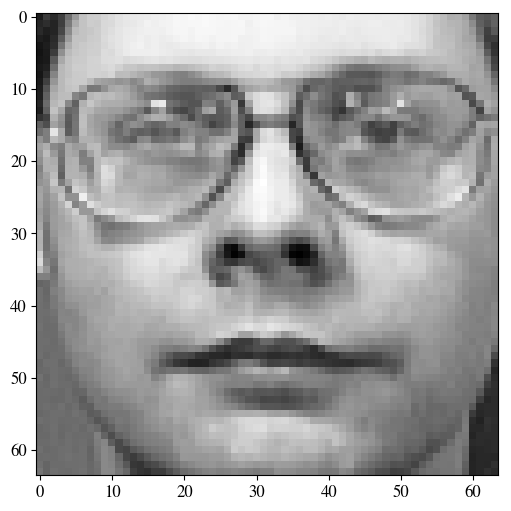

In [75]:
num_components = 400
eigenvalues, eigenvectors, mean_I = pca_calculation(I, num_components)
pca_reconstruction(30, num_components)

### Using Scikit decomposition PCA - look at the library, there are many alternatives

(400, 4096)


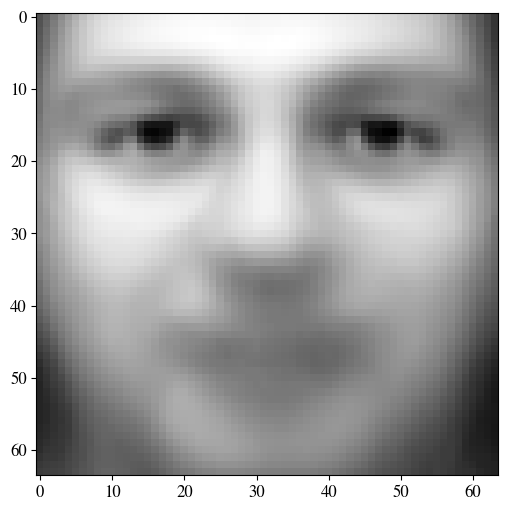

In [76]:
X = I
print(X.shape[0:2])
n_components = 40

pca = sklearn.decomposition.PCA(n_components)
# X is the matrix transposed (n samples on the rows, m features on the columns)
pca.fit(X)

X_proj = pca.transform(X)
mean_I = pca.mean_
eigenvectors = pca.components_.T

plt.figure()
plt.gray()
_ = plt.imshow(pca.mean_.reshape(m,n))

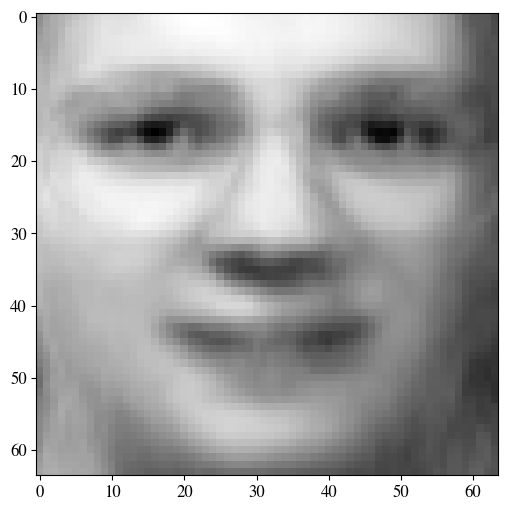

In [77]:
pca_reconstruction(50,8)

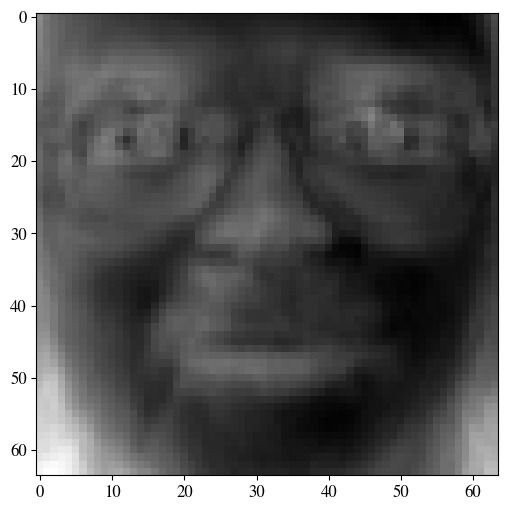

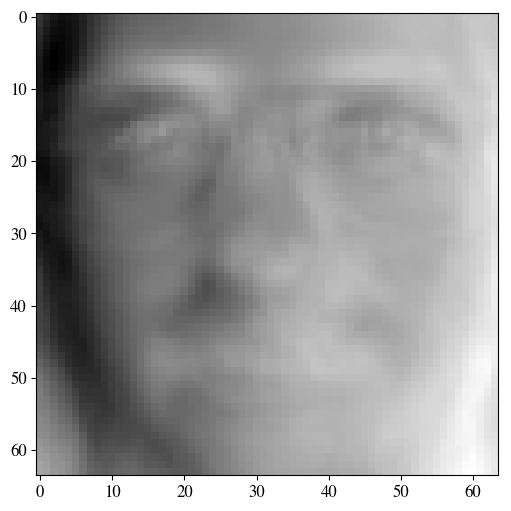

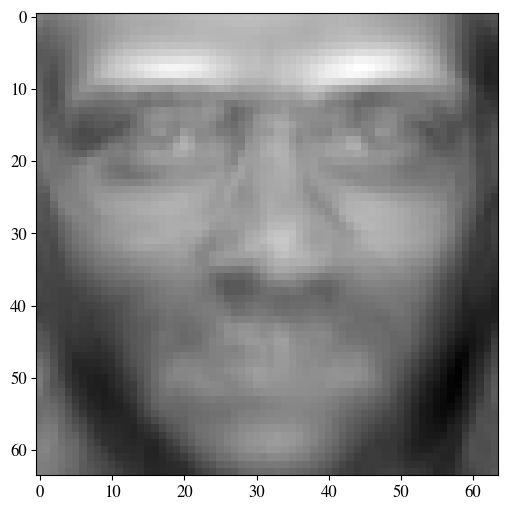

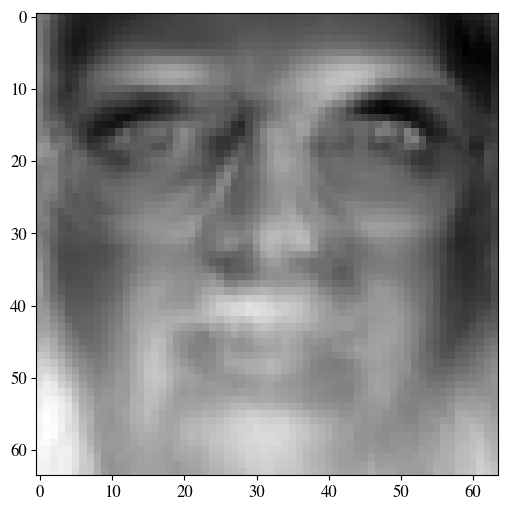

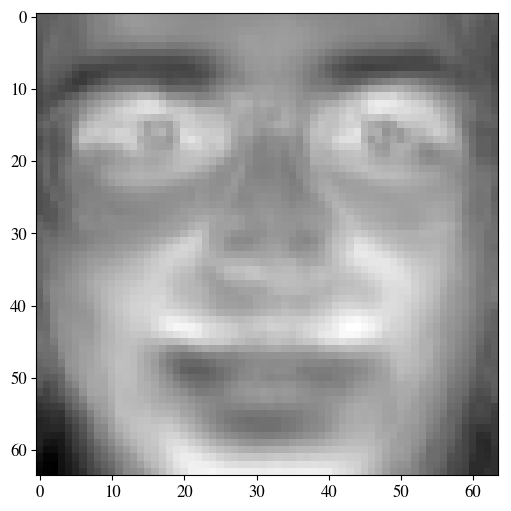

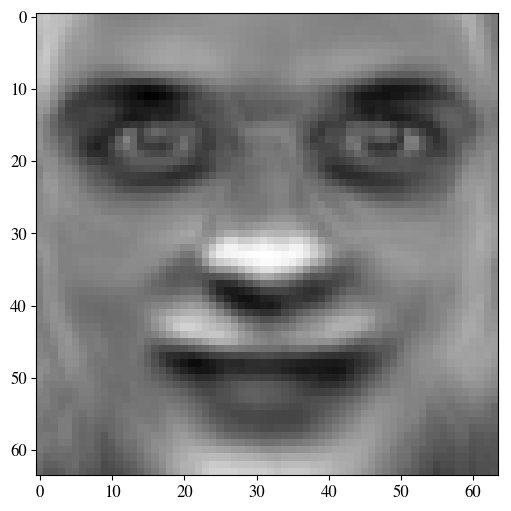

In [78]:
plt.figure()
plt.gray()
for i in [0,1,2,3,4,5]:
    plt.imshow(pca.components_[i,:].reshape(m,n))
    plt.show()

<a id='Principal-Component-Regression'></a>
[back to top](#top)

## The UCI automobile dataset
[The description is here](https://archive.ics.uci.edu/ml/datasets/Automobile)

In [79]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
auto = pd.read_csv(url, sep=',', header=None)

auto.replace('?', np.nan, inplace=True)
auto.dropna(axis=0, how='any', inplace=True)
auto[1] = auto[1].astype('int64')
auto.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.00,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.00,115,5500,18,22,17450
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.50,110,5500,19,25,17710
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.30,140,5500,17,20,23875
10,2,192,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.80,101,5800,23,29,16430
11,0,192,bmw,gas,std,four,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.80,101,5800,23,29,16925
12,0,188,bmw,gas,std,two,sedan,rwd,front,101.2,...,164,mpfi,3.31,3.19,9.00,121,4250,21,28,20970
13,0,188,bmw,gas,std,four,sedan,rwd,front,101.2,...,164,mpfi,3.31,3.19,9.00,121,4250,21,28,21105
18,2,121,chevrolet,gas,std,two,hatchback,fwd,front,88.4,...,61,2bbl,2.91,3.03,9.50,48,5100,47,53,5151
19,1,98,chevrolet,gas,std,two,hatchback,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.60,70,5400,38,43,6295


Make the first column, risk, the target variable and drop it from the dataframe.

In [80]:
auto = auto.reset_index(drop=True)
risk = auto[0]
loss = auto[1]
auto.drop([0,1], axis=1, inplace=True)

In [81]:
auto[18] = auto[18].astype('float64')
auto[19] = auto[19].astype('float64')
auto[21] = auto[21].astype('float64')
auto[22] = auto[22].astype('float64')
auto[25] = auto[25].astype('float64')
auto = auto.select_dtypes([np.number])

In [82]:
auto_scaled = auto.copy()
scaler = preprocessing.StandardScaler(copy=True, with_mean=True)
auto_scaled[:] = scaler.fit_transform(auto_scaled[:])
auto_scaled.describe()

,9,10,11,12,13,16,18,19,20,21,22,23,24,25
count,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02
mean,-1.016657e-15,2.846081e-15,5.010667e-15,1.628327e-15,-2.597503e-16,-1.640896e-16,2.308426e-15,1.546631e-15,-2.005733e-16,-2.555608e-16,9.712706e-16,8.658343e-17,4.426927e-16,-2.932665e-17
std,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00
min,-2.264382e+00,-2.726052e+00,-2.733387e+00,-1.989450e+00,-2.025585e+00,-1.917560e+00,-2.852323e+00,-3.967739e+00,-8.153080e-01,-1.562169e+00,-2.075946e+00,-1.895711e+00,-2.187001e+00,-1.079938e+00
25%,-7.307413e-01,-5.888313e-01,-8.278868e-01,-7.292889e-01,-8.235202e-01,-7.319784e-01,-9.385807e-01,-4.468386e-01,-3.768500e-01,-8.763838e-01,-6.759523e-01,-5.794748e-01,-6.339275e-01,-6.952536e-01
50%,-2.648250e-01,-1.204546e-03,-1.068868e-01,8.871045e-02,-2.521492e-01,-3.038518e-01,-1.130451e-01,1.144643e-01,-2.994751e-01,-2.559115e-01,1.855821e-01,-8.588645e-02,-1.269809e-02,-3.776412e-01
75%,4.922888e-01,4.688969e-01,4.596132e-01,7.077369e-01,7.251138e-01,5.194685e-01,9.751611e-01,5.907213e-01,-1.963085e-01,5.931560e-01,8.317329e-01,7.367609e-01,7.638387e-01,5.587265e-01
max,3.365439e+00,2.627881e+00,3.137613e+00,2.609033e+00,3.340515e+00,4.570205e+00,2.401086e+00,3.176117e+00,3.311356e+00,3.401610e+00,3.200952e+00,3.698291e+00,3.404064e+00,4.029508e+00


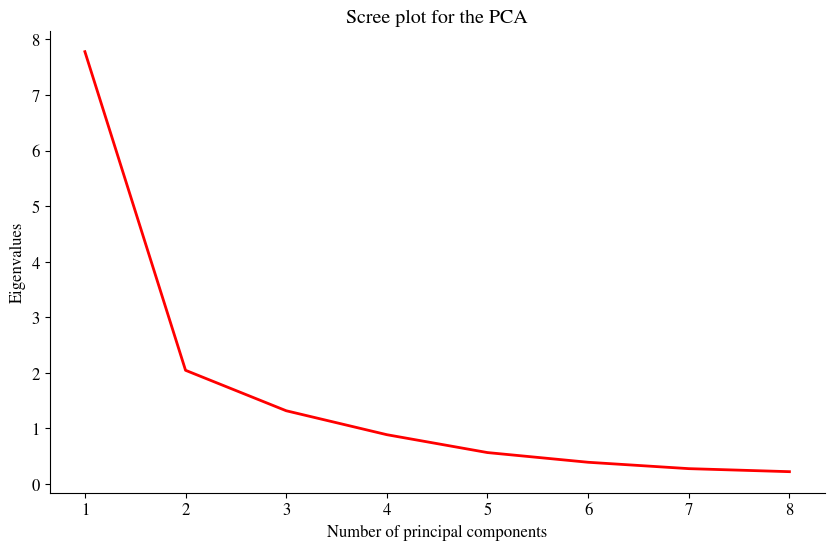

The 1st Principal Component explains 55.6 % of the variance

The 1st and 2nd Principal Components explain 70.2 % of the variance

The 1st, 2nd and 3rd Principal Components explain 79.6 % of the variance

The first four Principal Components explain 85.9 % of the variance



In [83]:
pca = sklearn.decomposition.PCA(n_components=8).fit(auto_scaled)

coef_PCA = pca.transform(auto_scaled)
eig = pca.explained_variance_
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
print ('The first four Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))

In [84]:
pca = sklearn.decomposition.PCA(n_components=4)

auto_proj = pca.fit_transform(auto_scaled)
mean_auto = pca.mean_
eigenvectors_auto = pca.components_.T

In [85]:
auto_proj_df = pd.DataFrame(auto_proj, columns = ['dimension1', 'dimension2', 'dimension3', 'dimension4'])

In [86]:
auto_proj_df.head()

,dimension1,dimension2,dimension3,dimension4
0,0.413885,-0.433333,-0.403975,1.123929
1,2.034757,-1.448552,-0.529596,0.950987
2,3.577836,-0.313214,-0.247209,1.862011
3,4.621975,-0.857512,-0.423106,1.990977
4,0.638847,-1.285617,1.397892,0.555535


In [87]:
auto_proj_df['loss'] =  loss

In [88]:
auto_proj_df.dtypes

dimension1    float64
dimension2    float64
dimension3    float64
dimension4    float64
loss            int64
dtype: object

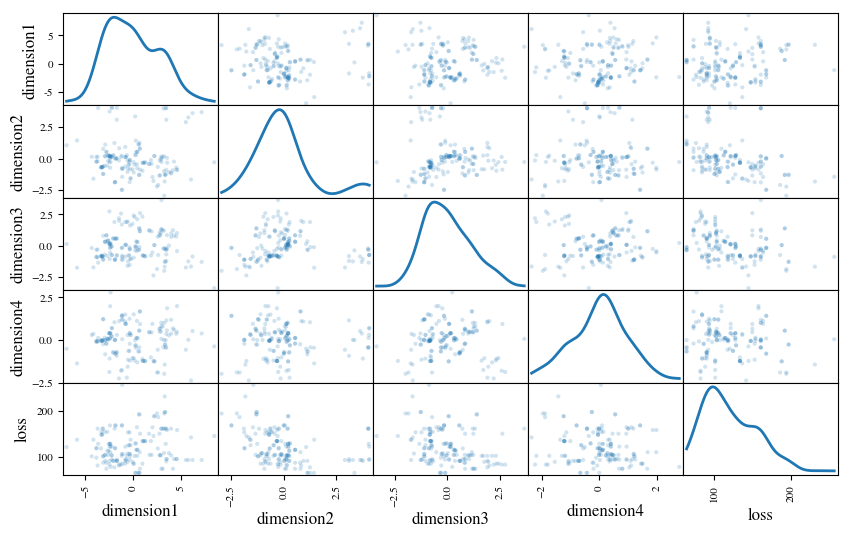

In [89]:
from pandas.plotting import scatter_matrix
_= scatter_matrix(auto_proj_df, alpha=0.2, figsize=(10, 6), diagonal='kde')

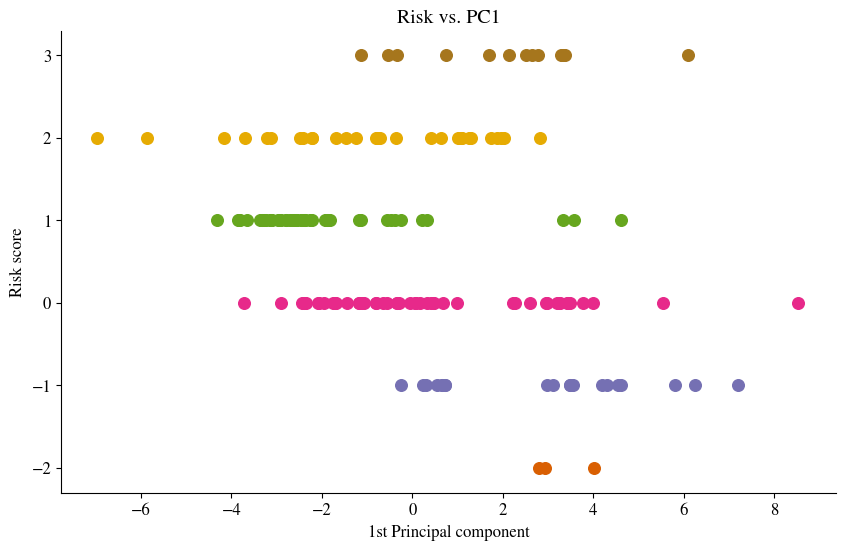

In [90]:
labels = [str(x) for x in list(range(-3,4))]
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], risk[i], s = 70, zorder=0, c=dark2_colors[(risk[i]+3)])
plt.ylabel('Risk score' )
plt.xlabel('1st Principal component' )
plt.title('Risk vs. PC1')
remove_border()
plt.show()

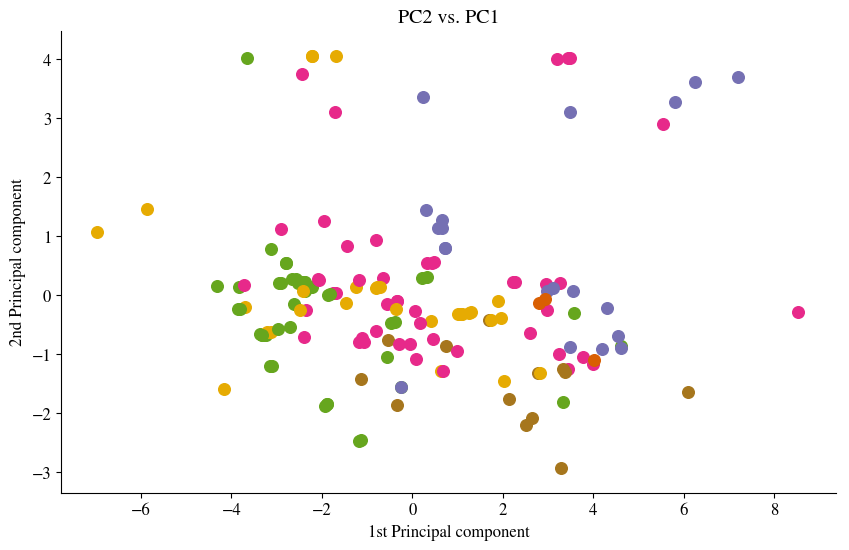

In [91]:
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], auto_proj[i,1], s = 70, zorder=0, c=dark2_colors[(risk[i]+3)])  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

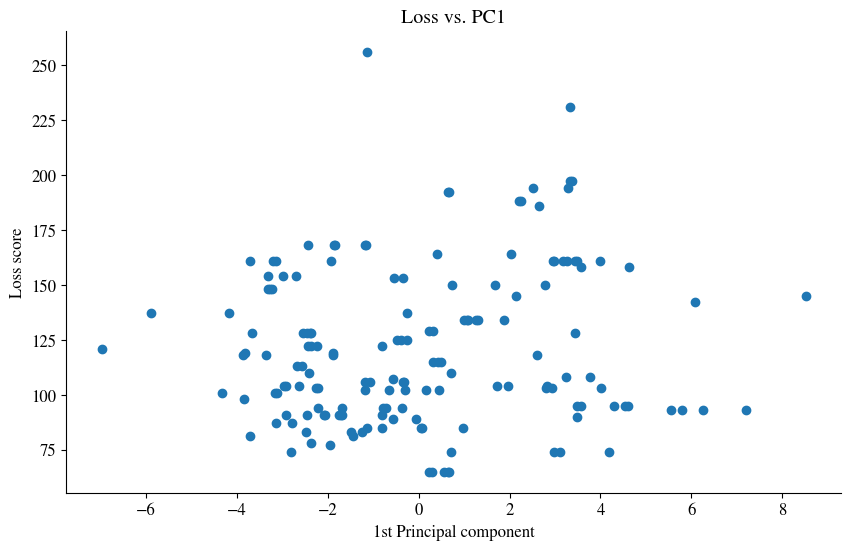

In [92]:
plt.figure(figsize=(10,6))
plt.scatter( auto_proj[:,0],loss)
plt.ylabel('Loss score' )
plt.xlabel('1st Principal component' )
plt.title('Loss vs. PC1')
remove_border()
plt.show()

[Pipeline example from SciKit Learn examples](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py)

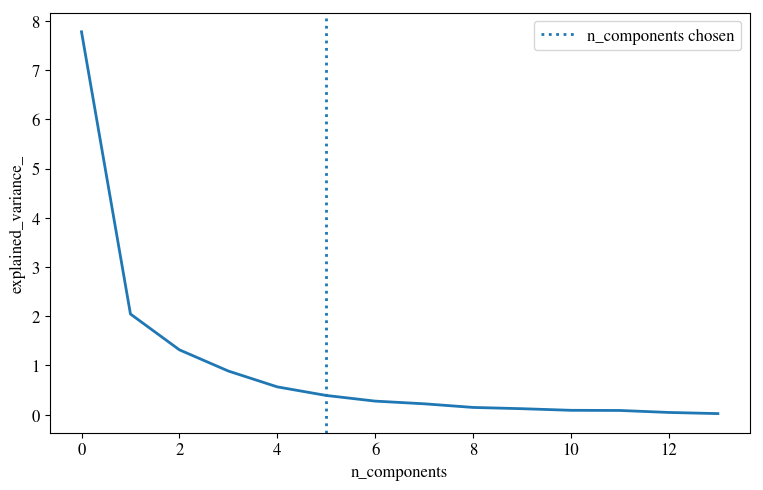

In [93]:
# source
# http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = decomposition.PCA()
linear = linear_model.LinearRegression(fit_intercept=True)

pipe = Pipeline(steps=[('pca', pca), ('linear regression', linear)])

# Plot the PCA spectrum
pca.fit(auto_scaled)

plt.figure(1, figsize=(10,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

n_components = [2,3,4,5,6,7,8, 9]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(auto_scaled, loss)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [94]:
pca = sklearn.decomposition.PCA(n_components=5)

auto_proj = pca.fit_transform(auto_scaled)
mean_auto = pca.mean_

linear.fit(auto_proj, loss)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [95]:
# 1988 Peugeot 405GRDT
fourofive = np.array([105.1, 173.5, 66.6, 55.4, 2535, 116.25, 3.27, 3.46, 21.8, 92, 4150,28,33,17950])
# 1995 BMW 325TD
bmw325 = np.array([106.3, 174.5, 66.9, 54.8, 2943, 152.44, 3.15, 3.27, 22, 113.5, 4800, 26.4, 46.1, 35000])
# 1987 Porsche 928 S4
porsche928 = np.array([98.40,178.0,72.30,50.50,3417,302,3.94,3.11,10.00,316,6000,12,25,46000])
# 2003 Volkswagen Passat TDI
vwpassat = np.array([106.4, 184.3, 68.7, 59.0, 3283, 120.1, 3.19, 3.76, 18.5, 134, 4000, 28, 37.3, 18000])
# 2016 Ford Mustang GT
mustang50 = np.array([107.1, 188.3, 75.4, 54.3, 3716, 302, 3.63, 3.65, 11, 435, 6500, 14.0, 17.0, 38000])

In [96]:
auto_test = np.vstack((fourofive,bmw325, porsche928, vwpassat, mustang50))
auto_test.shape


(5, 14)

First scale the new data with the standard scaler from above

In [97]:
# could do this, but in fact I want to use StandardScaler
auto_test_scaled = auto_test - scaler.mean_[np.newaxis, :]

In [98]:
auto_test_scaled = scaler.transform(auto_test)

And then transform into the PCA coordinates

In [99]:
test_coords = pca.transform(auto_test_scaled)

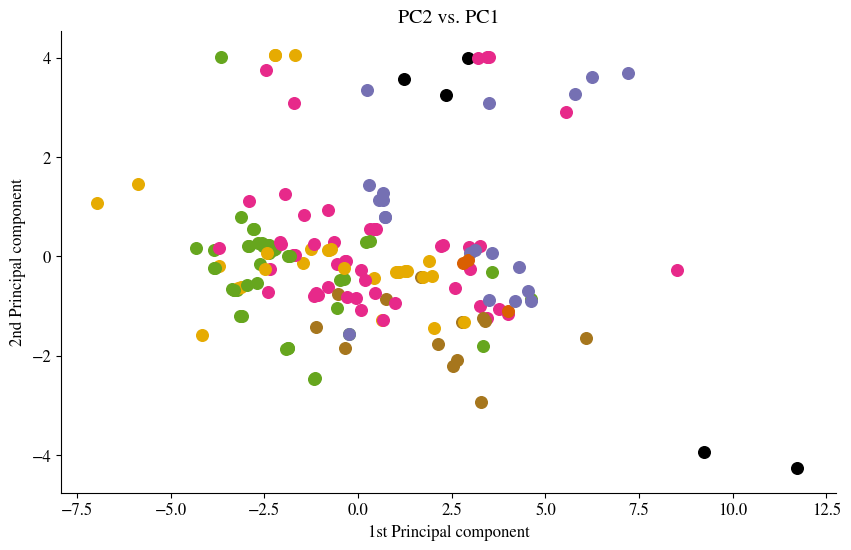

In [100]:
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], auto_proj[i,1], s = 70, zorder=1, c=dark2_colors[(risk[i]+3)])  
for i in range(test_coords.shape[0]):
    plt.scatter(test_coords[i,0], test_coords[i,1], s = 70, zorder=0, c='black') 
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

In [101]:
loss_fit = linear.predict(test_coords)

print (loss_fit)

[ 104.71396615  141.62579356  251.88723515   88.78273214  250.14256512]


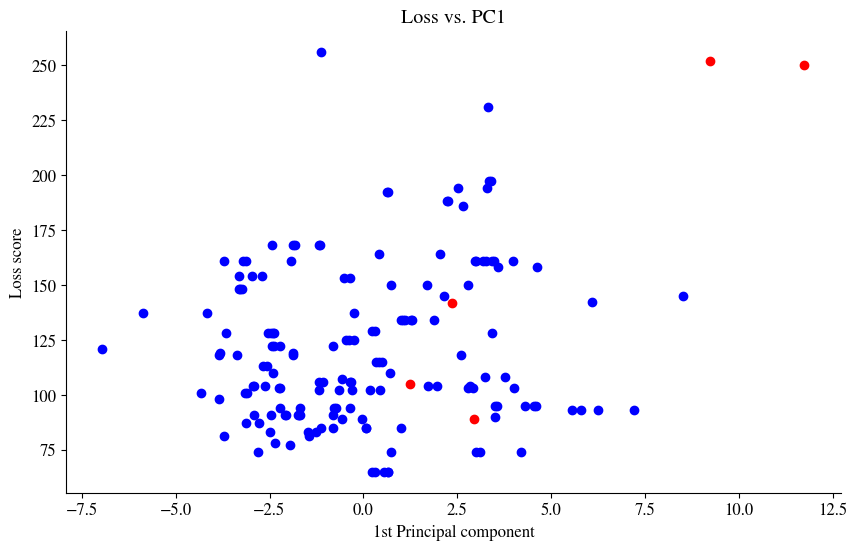

In [102]:
plt.figure(figsize=(10,6))
plt.scatter( auto_proj[:,0],loss, c='blue')
plt.scatter( test_coords[:,0],loss_fit, c='red')
plt.ylabel('Loss score' )
plt.xlabel('1st Principal component' )
plt.title('Loss vs. PC1')
remove_border()
plt.show()

<a id='Linear-Discriminant-Analysis'></a>
[back to top](#top)

## [Linear Discriminant Analysis](http://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)

### Principal Component Analysis vs. Linear Discriminant Analysis

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an “unsupervised” algorithm, since it “ignores” class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is “supervised” and computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes.


Discriminant analysis is a composite procedure with two distinct stages - dimensionality reduction (supervised) and classification stage. At dimensionality reduction we extract discriminant functions which replace the original explanatory variables. Then we classify (typically by Bayes' approach) observations to the classes using those functions.

http://sebastianraschka.com/Articles/2014_python_lda.html#principal-component-analysis-vs-linear-discriminant-analysis

### LDA (Supervised Classification)

In [103]:
auto_scaled.head()

,9,10,11,12,13,16,18,19,20,21,22,23,24,25
0,0.298157,0.364430,0.305113,0.177143,-0.258394,-0.336785,-0.413240,0.556703,-0.041559,0.201279,0.831733,-0.414945,-0.323313,0.427398
1,0.220504,0.364430,0.408113,0.177143,0.755296,0.552401,-0.413240,0.556703,-0.557392,0.625812,0.831733,-1.402122,-1.565772,1.024734
2,1.462948,1.766029,2.983113,0.796169,0.796925,0.552401,-0.413240,0.556703,-0.428433,0.462530,0.831733,-1.237593,-1.099850,1.069108
3,1.462948,1.766029,2.983113,0.884602,1.300648,0.387737,-0.638386,0.556703,-0.480017,1.442223,0.831733,-1.566652,-1.876386,2.121274
4,0.569942,0.381841,-0.415887,0.177143,-0.137667,-0.369717,0.750015,-1.484399,-0.351058,0.168622,1.477884,-0.579475,-0.478620,0.850653


In [104]:
binary_risk = (risk > -1) * 1.

In [105]:
x_train, x_test, y_train, y_test = train_test_split(auto_scaled,binary_risk, test_size=.35, random_state=10) 
print (x_train.shape,y_train.shape, x_test.shape,y_test.shape)

(103, 14) (103,) (56, 14) (56,)


In [106]:
clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)
ypred = clf.predict(x_test)
score = metrics.accuracy_score(y_test, ypred)
print("accuracy: %0.5f" % score)

accuracy: 0.85714


### LDA for Dimensionality Reduction (Supervised)

In [107]:
lda = LinearDiscriminantAnalysis(n_components=6)  #Number of components (< n_classes - 1) for dimensionality reduction.
auto_r2 = lda.fit(auto_scaled, risk).transform(auto_scaled)
auto_r2.shape

(159, 5)

Lets run the reduced dataset back with LDA classification. At this point any classification model can be used - RandomForest, SVM etc.

In [108]:
x_train, x_test, y_train, y_test = train_test_split(auto_r2,binary_risk, test_size=.35, random_state=10) 
print (x_train.shape,y_train.shape, x_test.shape,y_test.shape)

(103, 5) (103,) (56, 5) (56,)


In [109]:
clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)
ypred = clf.predict(x_test)
score = metrics.accuracy_score(y_test, ypred)
print("accuracy: %0.5f" % score)

accuracy: 0.87500


### Plot 3 dimensions

<IPython.core.display.Javascript object>


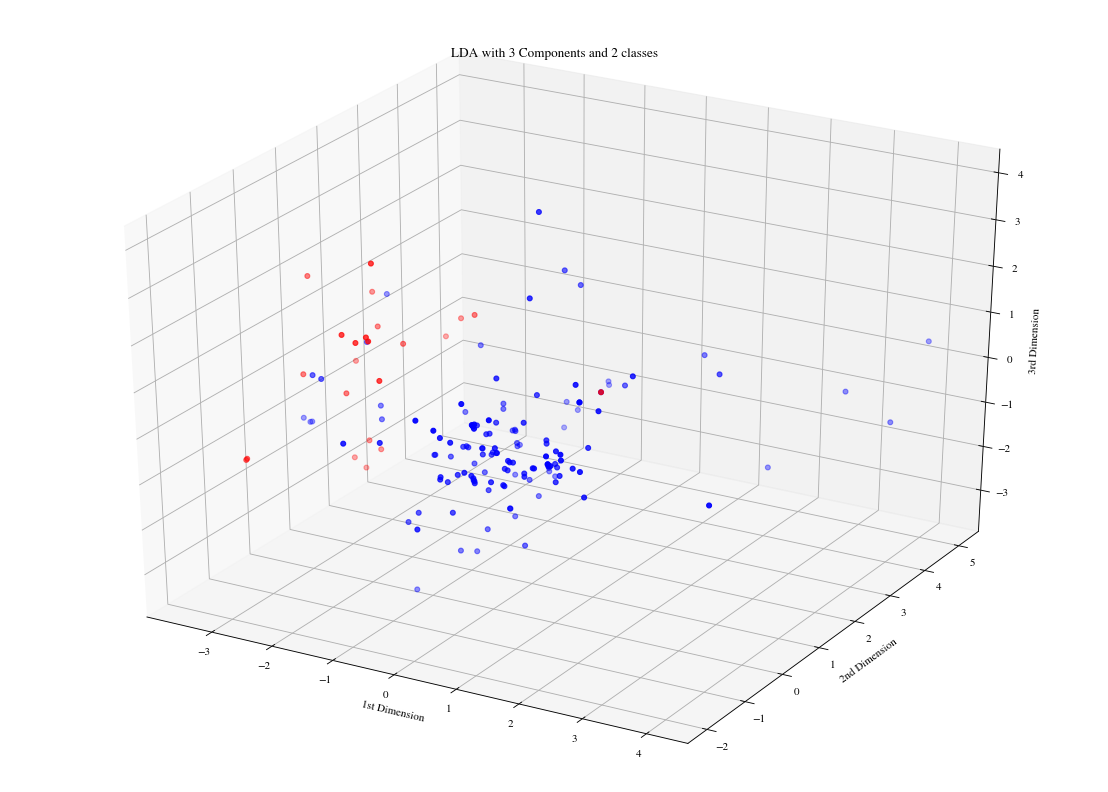

In [110]:
%matplotlib notebook
fig = plt.figure(figsize=(14,10))
ax = Axes3D(fig)

sequence_containing_x_vals = auto_r2[:,0] 
sequence_containing_y_vals = auto_r2[:,1] 
sequence_containing_z_vals = auto_r2[:,2] 

ax.set_zlabel('3rd Dimension' )
ax.set_ylabel('2nd Dimension' )
ax.set_xlabel('1st Dimension' )
ax.set_title("LDA with 3 Components and 2 classes")
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals,c=binary_risk,cmap=cmap_bold)
plt.draw()